In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load adata
ADATA_PATH = '../../results/spatial_clustering/st_conma/human_breast_cancer/human_breast_cancer_adata.h5ad'
OUTPUT_DIR = '../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8'
adata = sc.read_h5ad(ADATA_PATH)

In [3]:
import os
from adjustText import adjust_text

def plot_volcano(deg_df, target_domain, output_dir=None, logfc_thresh=0.25, pval_thresh=0.05, top_n=20, logfc_limit=None):
    """Create volcano plot for DEG results (target domain vs others).
    
    Args:
        logfc_limit: If set, exclude genes with |logfoldchanges| > logfc_limit from plot
    """
    print("\nCreating volcano plot...")

    fig, ax = plt.subplots(figsize=(10, 8))

    # Calculate -log10(pval_adj)
    deg_df = deg_df.copy()
    deg_df['neg_log10_pval'] = -np.log10(deg_df['pvals_adj'] + 1e-300)

    # Filter extreme logFC values if logfc_limit is set
    if logfc_limit is not None:
        n_before = len(deg_df)
        deg_df = deg_df[np.abs(deg_df['logfoldchanges']) <= logfc_limit]
        n_excluded = n_before - len(deg_df)
        print(f"  Excluded {n_excluded} genes with |logFC| > {logfc_limit}")

    # Categorize genes
    conditions = [
        (deg_df['pvals_adj'] < pval_thresh) & (deg_df['logfoldchanges'] > logfc_thresh),
        (deg_df['pvals_adj'] < pval_thresh) & (deg_df['logfoldchanges'] < -logfc_thresh),
    ]
    choices = ['Up', 'Down']
    deg_df['regulation'] = np.select(conditions, choices, default='NS')

    # Color mapping
    colors = {'Up': '#E41A1C', 'Down': '#377EB8', 'NS': '#999999'}

    # Plot
    for reg, color in colors.items():
        mask = deg_df['regulation'] == reg
        ax.scatter(
            deg_df.loc[mask, 'logfoldchanges'],
            deg_df.loc[mask, 'neg_log10_pval'],
            c=color, alpha=0.6, s=20, label=f'{reg} ({mask.sum()})'
        )

    # Add threshold lines
    ax.axhline(-np.log10(pval_thresh), color='gray', linestyle='--', linewidth=0.8)
    ax.axvline(logfc_thresh, color='gray', linestyle='--', linewidth=0.8)
    ax.axvline(-logfc_thresh, color='gray', linestyle='--', linewidth=0.8)

    # Set x-axis limits with padding
    x_min = deg_df['logfoldchanges'].min()
    x_max = deg_df['logfoldchanges'].max()
    x_range = x_max - x_min
    padding = x_range * 0.15
    ax.set_xlim(x_min - padding, x_max + padding)

    # Label top genes with adjustText to avoid overlapping
    top_up = deg_df[deg_df['regulation'] == 'Up'].nsmallest(top_n // 2, 'pvals_adj')
    top_down = deg_df[deg_df['regulation'] == 'Down'].nsmallest(top_n // 2, 'pvals_adj')
    top_genes = pd.concat([top_up, top_down])

    texts = []
    for _, row in top_genes.iterrows():
        texts.append(ax.text(
            row['logfoldchanges'], 
            row['neg_log10_pval'],
            row['gene'],
            fontsize=9,
            fontweight='bold'
        ))
    
    # Adjust text positions to avoid overlap
    adjust_text(
        texts, 
        ax=ax,
        arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
        expand_points=(2, 2),
        expand_text=(1.5, 1.5),
        force_points=(1, 1),
        force_text=(1, 1),
        only_move={'points': 'y', 'texts': 'xy'}
    )

    ax.set_xlabel('Log2 Fold Change', fontsize=12)
    ax.set_ylabel('-Log10(Adjusted P-value)', fontsize=12)
    ax.set_title(f'Volcano Plot: Domain {target_domain} vs Others', fontsize=14)
    ax.legend(loc='upper right')

    plt.tight_layout()

    # Save if output_dir is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f'volcano_domain{target_domain}_vs_others.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.savefig(output_path.replace('.png', '.pdf'), bbox_inches='tight')
        print(f"  Saved: {output_path}")
    
    plt.show()

/tmp/ipykernel_2890058/1519703935.py:22: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


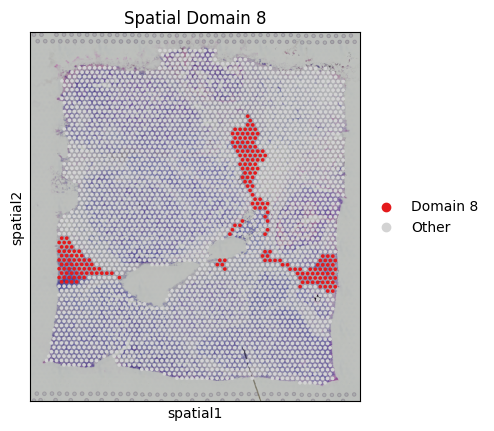

In [4]:
domain = ['8']

adata.obs['domain'] = adata.obs['domain'].astype(str)

# Create a new column for highlighted domains
adata.obs['domain_8'] = adata.obs['domain'].apply(
    lambda x: f'Domain {x}' if x in domain else 'Other'
)

category_order = [f'Domain {d}' for d in domain] + ['Other']
adata.obs['domain_8'] = pd.Categorical(
    adata.obs['domain_8'], 
    categories=category_order
)

# Custom color palette
palette = {
    'Domain 8': '#E41A1C',   # Red
    'Other': 'lightgray'
}

sc.pl.spatial(
    adata,
    color='domain_8',
    palette=palette,
    spot_size=200,
    title='Spatial Domain 8',
    show=True
)

### DEG Analysis

Target (Domain 8): 214 spots
Rest: 3584 spots


/NAS_Storage3/yeomtl/anaconda3/envs/st_conma/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


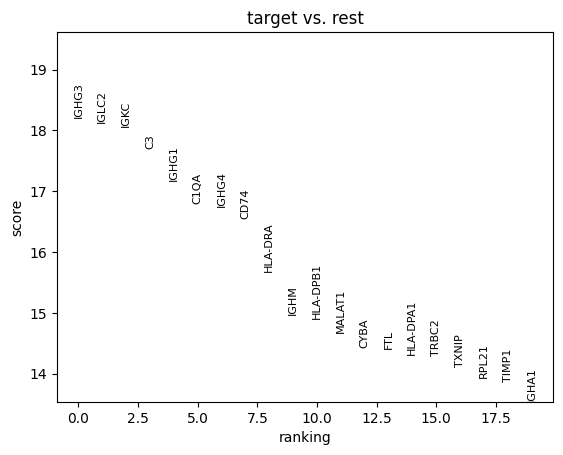

In [5]:
# Domain 2 vs 나머지 DEG 분석
target_domain = '8'

# domain을 target vs rest로 그룹화
adata.obs['domain'] = adata.obs['domain'].astype(str)
adata.obs['deg_group'] = adata.obs['domain'].apply(
    lambda x: 'target' if x == target_domain else 'rest'
)

print(f"Target (Domain {target_domain}): {(adata.obs['deg_group'] == 'target').sum()} spots")
print(f"Rest: {(adata.obs['deg_group'] == 'rest').sum()} spots")

# DEG 분석 실행
sc.tl.rank_genes_groups(
    adata,
    groupby='deg_group',
    groups=['target'],
    reference='rest',
    method='wilcoxon',
    pts=True
)

# 결과 출력
sc.pl.rank_genes_groups(adata, sharey=False, show=True)

In [6]:
# DEG 결과를 DataFrame으로 추출
result = adata.uns['rank_genes_groups']

deg_df = pd.DataFrame({
    'gene': result['names']['target'],
    'logfoldchanges': result['logfoldchanges']['target'],
    'pvals': result['pvals']['target'],
    'pvals_adj': result['pvals_adj']['target'],
    'scores': result['scores']['target'],
})

# Significant genes (padj < 0.01, |logFC| > 0.5)
deg_df['significant'] = (deg_df['pvals_adj'] < 0.05) & (np.abs(deg_df['logfoldchanges']) > 0.25)

print(f"Total genes: {len(deg_df)}")
print(f"Significant upregulated: {((deg_df['significant']) & (deg_df['logfoldchanges'] > 0)).sum()}")
print(f"Significant downregulated: {((deg_df['significant']) & (deg_df['logfoldchanges'] < 0)).sum()}")

print("\nTop 50 Upregulated in Domain 10:")
deg_df[deg_df['logfoldchanges'] > 0].head(50)

Total genes: 36601
Significant upregulated: 670
Significant downregulated: 5623

Top 50 Upregulated in Domain 10:


gene  logfoldchanges         pvals     pvals_adj     scores  \
0      IGHG3        2.208582  3.925479e-74  1.436765e-69  18.214981   
1      IGLC2        2.212587  2.244442e-73  4.107442e-69  18.119297   
2       IGKC        2.168081  7.211189e-73  8.797891e-69  18.054962   
3         C3        2.261791  4.286487e-70  3.922243e-66  17.698759   
4      IGHG1        2.062022  4.362351e-66  3.193328e-62  17.171209   
5       C1QA        1.976889  2.540546e-63  1.549775e-59  16.797615   
6      IGHG4        1.906890  6.762045e-63  3.535680e-59  16.739441   
7       CD74        1.707137  1.464746e-61  5.956797e-58  16.555355   
8    HLA-DRA        1.620680  2.352282e-55  7.826899e-52  15.671956   
9       IGHM        2.306530  1.038886e-50  3.168690e-47  14.976942   
10  HLA-DPB1        1.736531  3.205443e-50  8.380172e-47  14.901857   
11    MALAT1        1.435479  9.052254e-49  2.070760e-45  14.676989   
12      CYBA        1.756761  3.676872e-47  7.476511e-44  14.423594   
13       FTL        1.387861  4.719158e-47  9.090837e-44  14.406363   
14  HLA-DPA1        1.708215  2.030789e-46  3.539472e-43  14.305191   
15     TRBC2        2.593688  2.308526e-46  3.840653e-43  14.296271   
16     TXNIP        1.769518  3.117645e-45  4.564357e-42  14.113918   
17     RPL21        1.292999  4.002552e-44  5.634516e-41  13.932817   
18     TIMP1        1.689613  1.052072e-43  1.375245e-40  13.863636   
19     IGHA1        1.678370  9.190364e-42  1.019323e-38  13.539104   
20     IGLC3        2.285435  3.646460e-40  3.813260e-37  13.265975   
21  HLA-DRB1        1.365097  8.149894e-39  7.457357e-36  13.031031   
22     RPS11        0.987487  9.315627e-39  8.316129e-36  13.020827   
23    COL6A2        1.379675  1.405211e-37  1.118090e-34  12.811970   
24      CD52        2.510004  2.398040e-36  1.720993e-33  12.589957   
25    JCHAIN        2.379076  2.567490e-36  1.807167e-33  12.584566   
26      RPS9        1.185900  2.732138e-36  1.886773e-33  12.579657   
27       VIM        1.275775  4.554175e-36  3.030679e-33  12.539227   
28       BGN        1.566273  5.446107e-36  3.559517e-33  12.525044   
29      APOE        1.255337  8.136790e-36  5.224818e-33  12.493149   
30    LAPTM5        1.440852  3.607515e-35  2.237944e-32  12.374137   
31      IL32        1.882196  4.529599e-35  2.763131e-32  12.355847   
32   ZFP36L2        1.821618  6.935225e-35  4.094132e-32  12.321546   
33       C1S        1.635372  1.216632e-34  7.068245e-32  12.276142   
34      TRAC        2.411885  2.742071e-34  1.520645e-31  12.210202   
35  HLA-DRB5        1.332050  5.465764e-34  2.985857e-31  12.153953   
36  SERPINF1        1.721418  1.480159e-33  7.966958e-31  12.072258   
37       DCN        1.542270  2.274334e-33  1.189184e-30  12.036866   
38     IGLC1        1.411453  4.200487e-33  2.165380e-30  11.986135   
39     RPL36        0.840352  7.505900e-33  3.815604e-30  11.937941   
40     AEBP1        1.285339  3.563190e-32  1.738884e-29  11.807665   
41     FXYD5        1.941491  4.126708e-32  1.987390e-29  11.795312   
42     HLA-E        1.132794  1.638319e-31  7.590396e-29  11.678674   
43      C1QB        1.322305  2.070663e-31  9.473540e-29  11.658748   
44    CCDC80        1.785688  5.550308e-31  2.477400e-28  11.574486   
45      LRP1        1.827847  8.371020e-31  3.691418e-28  11.539189   
46       C1R        1.790209  9.015841e-31  3.928438e-28  11.532804   
47       LYZ        1.303037  9.691868e-31  4.173318e-28  11.526579   
48      RPS3        1.073798  4.149228e-30  1.725749e-27  11.400668   
49       LUM        1.348875  7.550654e-30  3.036939e-27  11.348430   

    significant  
0          True  
1          True  
2          True  
3          True  
4          True  
5          True  
6          True  
7          True  
8          True  
9          True  
10         True  
11         True  
12         True  
13         True  
14         True  
15         True  
16         True  
17         True  
18         True  
19         True  
20      

In [7]:
# Save upregulated DEGs to CSV
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Filter significant upregulated genes
deg_up_df = deg_df[(deg_df['logfoldchanges'] > 0) & (deg_df['significant'])]

# Save significant upregulated genes
deg_up_df_sorted = deg_up_df.sort_values('pvals_adj')
output_csv = os.path.join(OUTPUT_DIR, 'deg_domain8_upregulated.csv')
deg_up_df_sorted.to_csv(output_csv, index=False)
print(f"Saved {len(deg_up_df_sorted)} upregulated DEGs to: {output_csv}")

# Also save all DEGs for reference
output_csv_all = os.path.join(OUTPUT_DIR, 'deg_domain8_all.csv')
deg_df.to_csv(output_csv_all, index=False)
print(f"Saved all {len(deg_df)} DEGs to: {output_csv_all}")

Saved 670 upregulated DEGs to: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/deg_domain8_upregulated.csv
Saved all 36601 DEGs to: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/deg_domain8_all.csv



Creating volcano plot...


  Excluded 6480 genes with |logFC| > 5


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/volcano_domain8_vs_others.png


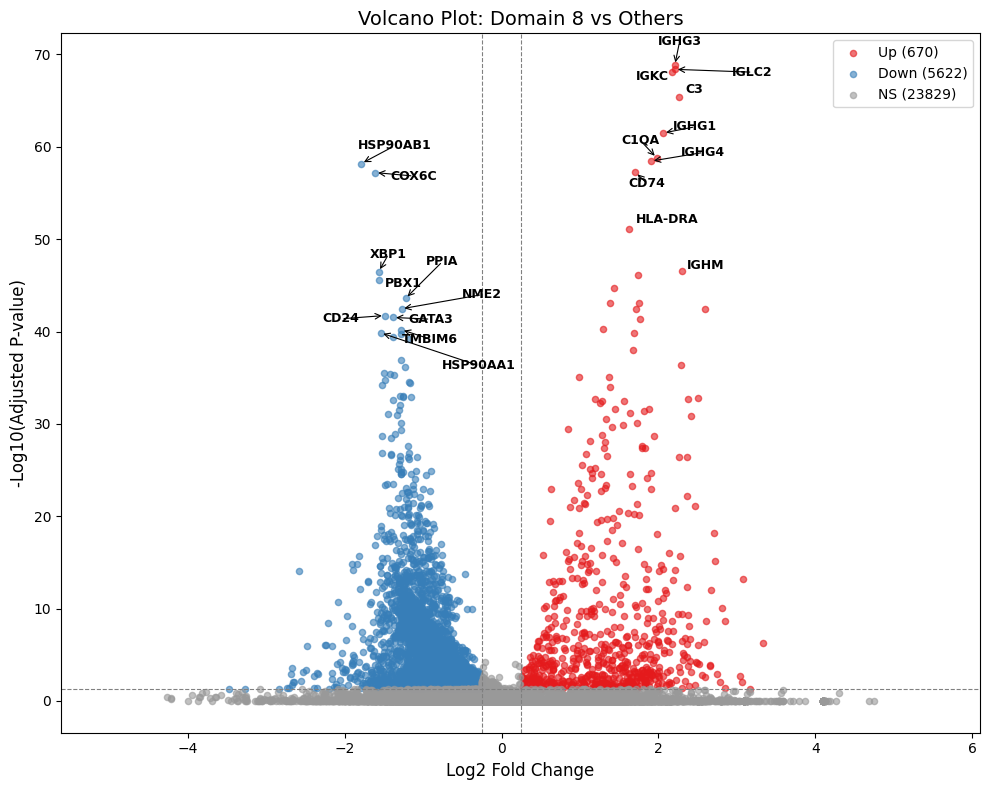

In [8]:
# Volcano plot for Domain 8 vs Others
plot_volcano(
    deg_df, 
    target_domain='8', 
    output_dir=OUTPUT_DIR, 
    logfc_thresh=0.25, 
    pval_thresh=0.05, 
    top_n=20,
    logfc_limit=5  # Exclude genes with |logFC| > 5
)

Top 5 upregulated genes in Domain 8:
['IGHG3', 'IGLC2', 'IGKC', 'C3', 'IGHG1']


/NAS_Storage3/yeomtl/anaconda3/envs/st_conma/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:961: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/NAS_Storage3/yeomtl/anaconda3/envs/st_conma/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:961: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/NAS_Storage3/yeomtl/anaconda3/envs/st_conma/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:961: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/NAS_Storage3/yeomtl/anaconda3/envs/st_conma/lib/python3.10/site-packages/sc

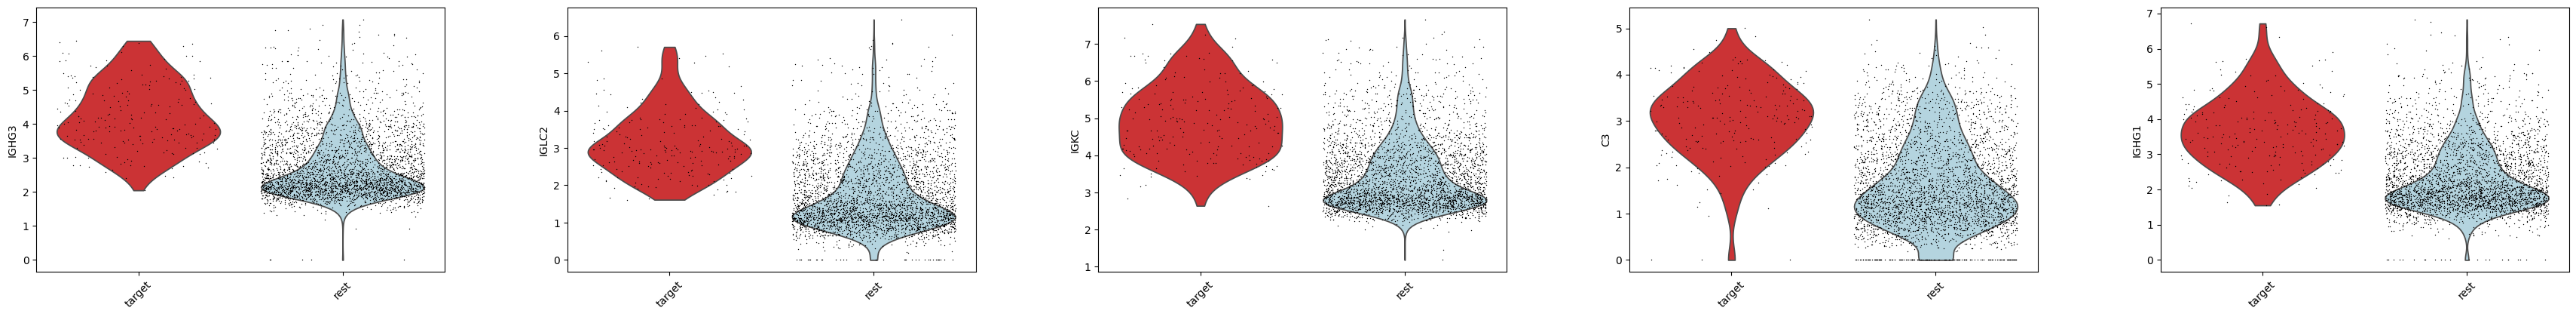

In [9]:
# Violin plot for top upregulated genes in Domain 8 vs Others
# Select top N significant upregulated genes
top_n_genes = 5
top_genes = deg_df[(deg_df['logfoldchanges'] > 0) & (deg_df['significant'])].head(top_n_genes)['gene'].tolist()

print(f"Top {top_n_genes} upregulated genes in Domain 8:")
print(top_genes)

# Create violin plot
sc.pl.violin(
    adata,
    keys=top_genes,
    groupby='deg_group',
    rotation=45,
    order=['target', 'rest'],
    palette={'target': '#E41A1C', 'rest': 'lightblue'},
    stripplot=True,
    jitter=0.4,
    size=1,
    show=True
)

/NAS_Storage3/yeomtl/anaconda3/envs/st_conma/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:961: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2890058/2628729698.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Domain 8', 'Other'])
/NAS_Storage3/yeomtl/anaconda3/envs/st_conma/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:961: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2890058/2628729698.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocato

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/violin_domain8_top_genes.png


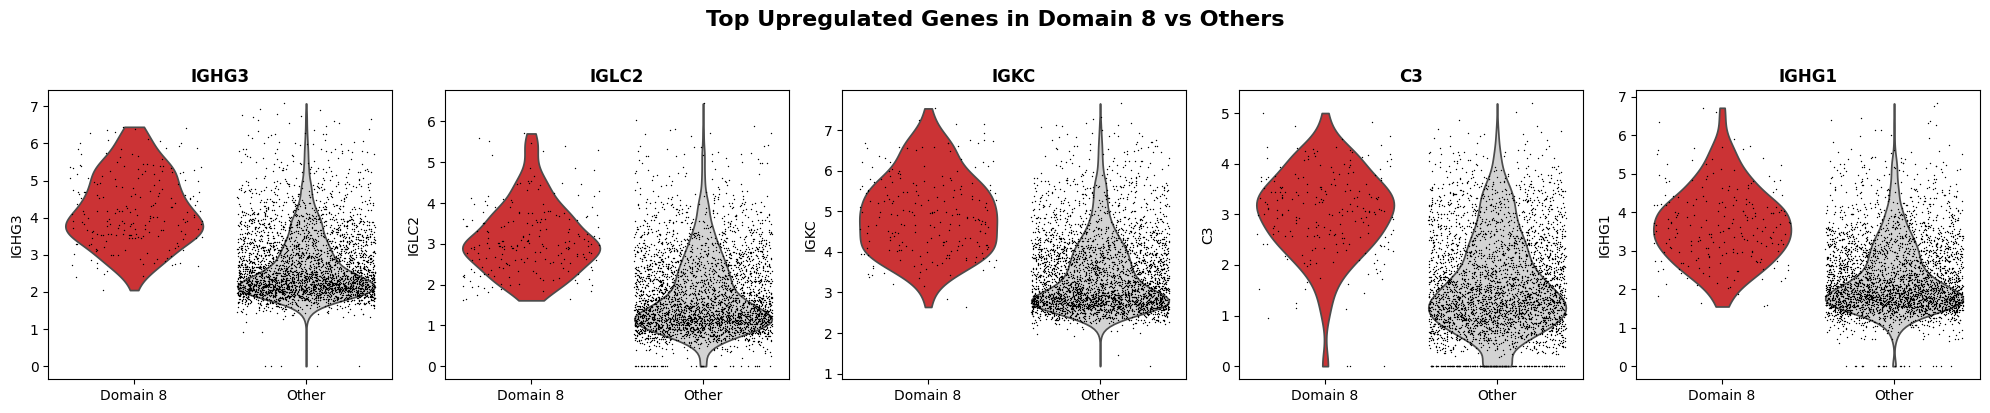

In [10]:
# Save violin plot to file
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()

for i, gene in enumerate(top_genes):
    sc.pl.violin(
        adata,
        keys=gene,
        groupby='deg_group',
        order=['target', 'rest'],
        palette={'target': '#E41A1C', 'rest': 'lightgray'},
        stripplot=True,
        jitter=0.4,
        size=1,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(gene, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    # Update x-tick labels
    axes[i].set_xticklabels(['Domain 8', 'Other'])

plt.suptitle('Top Upregulated Genes in Domain 8 vs Others', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save
output_path = os.path.join(OUTPUT_DIR, 'violin_domain8_top_genes.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.savefig(output_path.replace('.png', '.pdf'), bbox_inches='tight')
print(f"Saved: {output_path}")
plt.show()

Domain 8 spots: 214
X range: 4866.0 - 19886.0
X threshold (left 1/3): 9872.7

Subregion counts:
subregion
center_right    151
left_lower       63
Name: count, dtype: int64


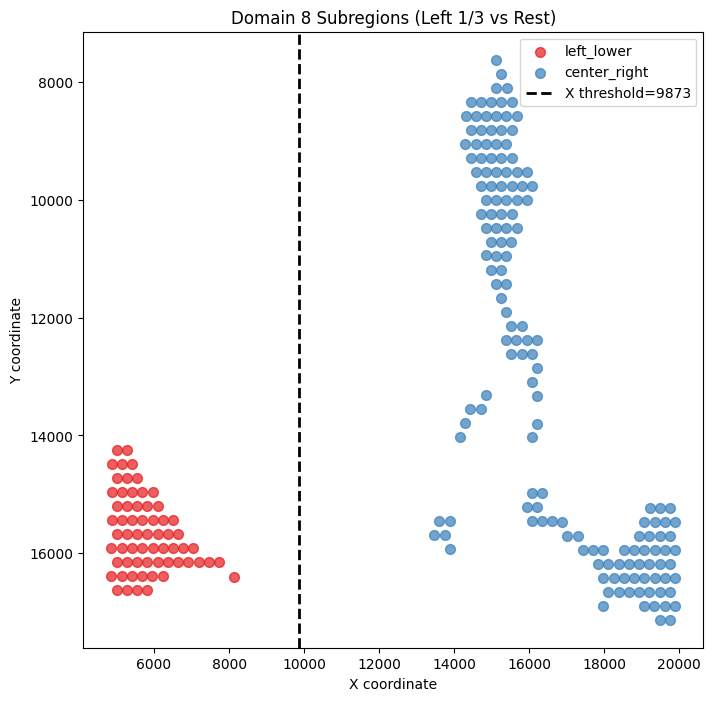

In [11]:
# Extract Domain 8 spots for subregion analysis
domain_8 = adata[adata.obs['domain'] == '8'].copy()
print(f"Domain 8 spots: {domain_8.n_obs}")

# Get spatial coordinates
spatial_coords = domain_8.obsm['spatial']
x_coords = spatial_coords[:, 0]
y_coords = spatial_coords[:, 1]

x_min = x_coords.min()
x_max = x_coords.max()
x_threshold = x_min + (x_max - x_min) / 3
print(f"X range: {x_min:.1f} - {x_max:.1f}")
print(f"X threshold (left 1/3): {x_threshold:.1f}")

domain_8.obs['subregion'] = np.where(
    spatial_coords[:, 0] < x_threshold,
    'left_lower',   
    'center_right' 
)

print(f"\nSubregion counts:")
print(domain_8.obs['subregion'].value_counts())

fig, ax = plt.subplots(figsize=(8, 8))
colors = {'left_lower': '#E41A1C', 'center_right': '#377EB8'}
for region, color in colors.items():
    mask = domain_8.obs['subregion'] == region
    ax.scatter(
        spatial_coords[mask, 0], 
        spatial_coords[mask, 1], 
        c=color, s=50, alpha=0.7, label=region
    )
ax.axvline(x_threshold, color='black', linestyle='--', linewidth=2, label=f'X threshold={x_threshold:.0f}')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('Domain 8 Subregions (Left 1/3 vs Rest)')
ax.legend()
ax.invert_yaxis()
plt.show()

/tmp/ipykernel_2890058/653784247.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


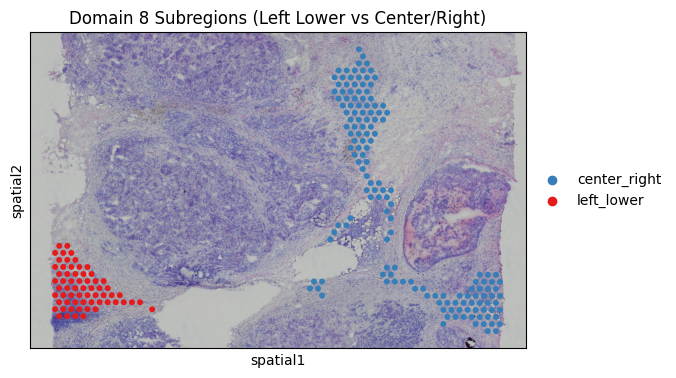

In [12]:
sc.pl.spatial(
    domain_8,
    color='subregion',
    palette={'left_lower': '#E41A1C', 'center_right': '#377EB8'},
    spot_size=200,
    title='Domain 8 Subregions (Left Lower vs Center/Right)',
    show=True
)

DEG Analysis: Left Lower vs Center/Right in Domain 8
Left Lower: 63 spots
Center/Right: 151 spots


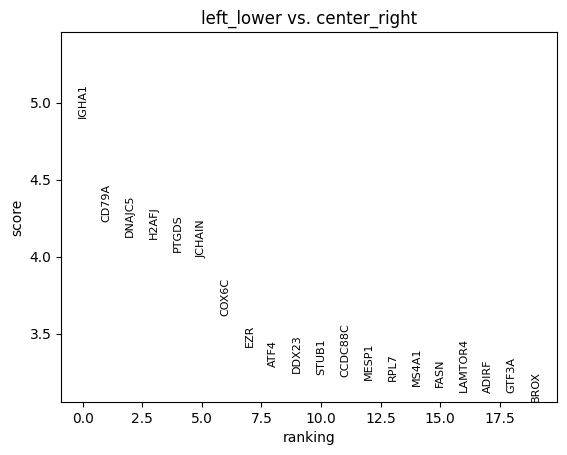

In [13]:
print("DEG Analysis: Left Lower vs Center/Right in Domain 8")
print(f"Left Lower: {(domain_8.obs['subregion'] == 'left_lower').sum()} spots")
print(f"Center/Right: {(domain_8.obs['subregion'] == 'center_right').sum()} spots")

sc.tl.rank_genes_groups(
    domain_8,
    groupby='subregion',
    groups=['left_lower'],
    reference='center_right',
    method='wilcoxon',
    pts=True
)

sc.pl.rank_genes_groups(domain_8, sharey=False, show=True)

In [14]:
result_sub = domain_8.uns['rank_genes_groups']

deg_subregion_df = pd.DataFrame({
    'gene': result_sub['names']['left_lower'],
    'logfoldchanges': result_sub['logfoldchanges']['left_lower'],
    'pvals': result_sub['pvals']['left_lower'],
    'pvals_adj': result_sub['pvals_adj']['left_lower'],
    'scores': result_sub['scores']['left_lower'],
})

deg_subregion_df['significant'] = (deg_subregion_df['pvals_adj'] < 0.05) & (np.abs(deg_subregion_df['logfoldchanges']) > 0.25)

print(f"Total genes: {len(deg_subregion_df)}")
print(f"Significant upregulated in Left Lower: {((deg_subregion_df['significant']) & (deg_subregion_df['logfoldchanges'] > 0)).sum()}")
print(f"Significant downregulated in Left Lower: {((deg_subregion_df['significant']) & (deg_subregion_df['logfoldchanges'] < 0)).sum()}")

print("\nTop 30 Upregulated in Left Lower (vs Center/Right):")
deg_subregion_df[deg_subregion_df['logfoldchanges'] > 0].head(30)

Total genes: 36601
Significant upregulated in Left Lower: 4
Significant downregulated in Left Lower: 25

Top 30 Upregulated in Left Lower (vs Center/Right):


gene  logfoldchanges         pvals  pvals_adj    scores  significant
0     IGHA1        1.215053  9.401276e-07   0.003128  4.903774         True
1     CD79A        2.055212  2.370753e-05   0.034709  4.226765         True
2    DNAJC5        1.751681  3.629587e-05   0.047445  4.129876         True
3     H2AFJ        0.868676  3.845793e-05   0.048538  4.116554         True
4     PTGDS        1.458706  5.593028e-05   0.066036  4.029354        False
5    JCHAIN        1.223695  6.457333e-05   0.070949  3.995443        False
6     COX6C        0.390742  3.029863e-04   0.242207  3.612733        False
7       EZR        0.937028  6.314223e-04   0.412691  3.417745        False
8      ATF4        0.989667  1.025950e-03   0.605658  3.283312        False
9     DDX23        1.281570  1.166370e-03   0.656774  3.246979        False
10    STUB1        1.069624  1.211839e-03   0.662008  3.236079        False
11  CCDC88C        1.677441  1.285831e-03   0.675170  3.219123        False
12    MESP1        1.149971  1.381280e-03   0.694760  3.198534        False
13     RPL7        0.676754  1.392929e-03   0.694760  3.196112        False
14    MS4A1        2.485399  1.565813e-03   0.744290  3.162201        False
15     FASN        0.846256  1.592063e-03   0.747066  3.157357        False
16  LAMTOR4        0.967885  1.787467e-03   0.817789  3.123446        False
17    ADIRF        0.841365  1.817115e-03   0.821089  3.118602        False
18    GTF3A        0.958888  1.839648e-03   0.821133  3.114968        False
19     BROX        1.112872  2.227853e-03   0.941701  3.058046        False
20   HNRNPU        0.909163  2.264137e-03   0.941701  3.053202        False
21    CXCR4        1.415761  2.414753e-03   0.960678  3.033824        False
22    VAC14        1.278791  2.513488e-03   0.989206  3.021713        False
23      AK1        1.207453  2.543821e-03   0.990494  3.018080        False
24   HSPBP1        1.266138  2.700568e-03   1.000000  2.999913        False
25     MMP9        0.901605  2.743832e-03   1.000000  2.995069        False
26  HNRNPA0        0.888007  2.877451e-03   1.000000  2.980535        False
27    NELFE        0.999727  3.016986e-03   1.000000  2.966002        False
28    EIF4B        0.843644  3.028888e-03   1.000000  2.964791        False
29     NACA        0.637997  3.052820e-03   1.000000  2.962369        False

In [15]:
# Save DEG results to CSV
OUTPUT_DIR_SUB = os.path.join(OUTPUT_DIR, 'subregion_deg')
os.makedirs(OUTPUT_DIR_SUB, exist_ok=True)

# Save all DEGs
output_csv_sub = os.path.join(OUTPUT_DIR_SUB, 'deg_leftlower_vs_centerright.csv')
deg_subregion_df.to_csv(output_csv_sub, index=False)
print(f"Saved all DEGs to: {output_csv_sub}")

# Save significant upregulated in left lower
deg_sub_up = deg_subregion_df[(deg_subregion_df['logfoldchanges'] > 0) & (deg_subregion_df['significant'])]
output_csv_sub_up = os.path.join(OUTPUT_DIR_SUB, 'deg_leftlower_upregulated.csv')
deg_sub_up.sort_values('pvals_adj').to_csv(output_csv_sub_up, index=False)
print(f"Saved {len(deg_sub_up)} upregulated DEGs to: {output_csv_sub_up}")

# Save significant upregulated in center/right (downregulated in left_lower)
deg_sub_down = deg_subregion_df[(deg_subregion_df['logfoldchanges'] < 0) & (deg_subregion_df['significant'])]
output_csv_sub_down = os.path.join(OUTPUT_DIR_SUB, 'deg_centerright_upregulated.csv')
deg_sub_down.sort_values('pvals_adj').to_csv(output_csv_sub_down, index=False)
print(f"Saved {len(deg_sub_down)} center/right upregulated DEGs to: {output_csv_sub_down}")

Saved all DEGs to: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/deg_leftlower_vs_centerright.csv
Saved 4 upregulated DEGs to: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/deg_leftlower_upregulated.csv
Saved 25 center/right upregulated DEGs to: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/deg_centerright_upregulated.csv



Creating volcano plot...
  Excluded 3244 genes with |logFC| > 3
  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/volcano_domainLeftLower_vs_CenterRight_vs_others.png


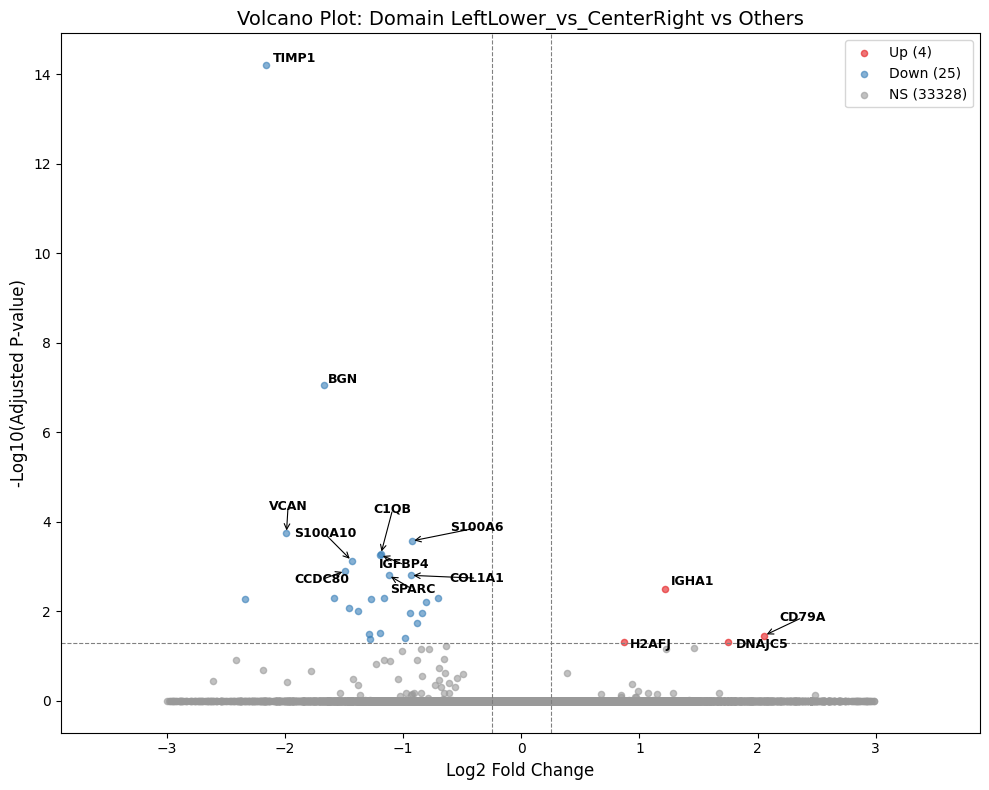

In [16]:
# Volcano plot for subregion DEG
plot_volcano(
    deg_subregion_df, 
    target_domain='LeftLower_vs_CenterRight', 
    output_dir=OUTPUT_DIR_SUB, 
    logfc_thresh=0.25, 
    pval_thresh=0.05, 
    top_n=20,
    logfc_limit=3
)

/tmp/ipykernel_2890058/1845299321.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


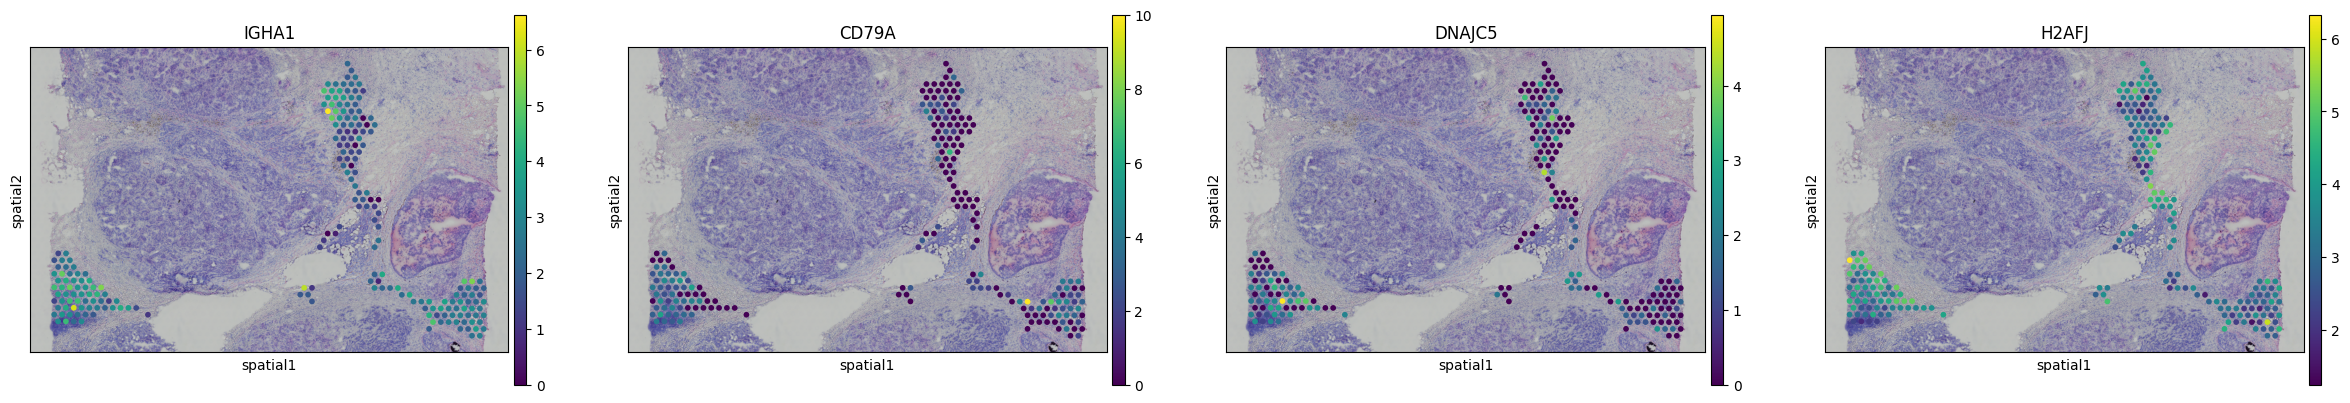

In [17]:
sc.pl.spatial(
    domain_8,
    color=("IGHA1", "CD79A", "DNAJC5", "H2AFJ"),
    spot_size=200,
    ncols=4,
    show=True
)

In [18]:
# ============================================
# GO & KEGG Enrichment Analysis for Domain 8 DEGs
# ============================================
# Required packages: gseapy (pip install gseapy)

import gseapy as gp
from gseapy import enrichr

def run_enrichment_analysis(gene_list, gene_sets, organism='human', output_dir=None, prefix=''):
    """
    Run enrichment analysis using Enrichr.
    
    Parameters:
    -----------
    gene_list : list
        List of gene symbols
    gene_sets : list
        List of gene set libraries to use (e.g., ['GO_Biological_Process_2023', 'KEGG_2021_Human'])
    organism : str
        Organism name
    output_dir : str
        Output directory for saving results
    prefix : str
        Prefix for output files
    
    Returns:
    --------
    dict : Dictionary of enrichment results DataFrames
    """
    results = {}
    
    for gene_set in gene_sets:
        print(f"\nRunning enrichment for: {gene_set}")
        try:
            enr = gp.enrichr(
                gene_list=gene_list,
                gene_sets=gene_set,
                organism=organism,
                outdir=None,  # Don't save automatically
                cutoff=0.05
            )
            results[gene_set] = enr.results
            print(f"  Found {len(enr.results)} enriched terms")
            
            # Save to CSV if output_dir is provided
            if output_dir:
                csv_path = os.path.join(output_dir, f'{prefix}enrichr_{gene_set.replace(" ", "_")}.csv')
                enr.results.to_csv(csv_path, index=False)
                print(f"  Saved: {csv_path}")
                
        except Exception as e:
            print(f"  Error: {e}")
            results[gene_set] = pd.DataFrame()
    
    return results


def plot_enrichment_barplot(enr_df, title='Enrichment Analysis', top_n=15, 
                            output_path=None, figsize=(12, 8), color='#E41A1C'):
    """
    Create bar plot for enrichment results.
    
    Parameters:
    -----------
    enr_df : pd.DataFrame
        Enrichment results from enrichr
    title : str
        Plot title
    top_n : int
        Number of top terms to show
    output_path : str
        Path to save the plot
    figsize : tuple
        Figure size
    color : str
        Bar color
    """
    if enr_df.empty:
        print("No enrichment results to plot")
        return
    
    # Filter significant results and get top N
    sig_df = enr_df[enr_df['Adjusted P-value'] < 0.05].head(top_n)
    
    if sig_df.empty:
        print("No significant enrichment results (Adjusted P-value < 0.05)")
        return
    
    # Calculate -log10(adjusted p-value)
    sig_df = sig_df.copy()
    sig_df['neg_log10_pval'] = -np.log10(sig_df['Adjusted P-value'] + 1e-300)
    
    # Truncate long term names
    sig_df['Term_short'] = sig_df['Term'].apply(lambda x: x[:60] + '...' if len(x) > 60 else x)
    
    # Sort by p-value (most significant at top)
    sig_df = sig_df.sort_values('neg_log10_pval', ascending=True)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    bars = ax.barh(sig_df['Term_short'], sig_df['neg_log10_pval'], color=color, alpha=0.8)
    
    ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axvline(x=-np.log10(0.05), color='gray', linestyle='--', linewidth=1, label='p=0.05')
    
    # Add gene count annotations
    for i, (idx, row) in enumerate(sig_df.iterrows()):
        gene_count = len(row['Genes'].split(';')) if isinstance(row['Genes'], str) else 0
        ax.text(row['neg_log10_pval'] + 0.1, i, f"n={gene_count}", va='center', fontsize=9)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.savefig(output_path.replace('.png', '.pdf'), bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    plt.show()


def plot_enrichment_dotplot(enr_df, title='Enrichment Analysis', top_n=15,
                            output_path=None, figsize=(10, 8)):
    """
    Create dot plot for enrichment results (similar to clusterProfiler style).
    
    Parameters:
    -----------
    enr_df : pd.DataFrame
        Enrichment results from enrichr
    title : str
        Plot title
    top_n : int
        Number of top terms to show
    output_path : str
        Path to save the plot
    figsize : tuple
        Figure size
    """
    if enr_df.empty:
        print("No enrichment results to plot")
        return
    
    # Filter significant results and get top N
    sig_df = enr_df[enr_df['Adjusted P-value'] < 0.05].head(top_n)
    
    if sig_df.empty:
        print("No significant enrichment results (Adjusted P-value < 0.05)")
        return
    
    sig_df = sig_df.copy()
    sig_df['neg_log10_pval'] = -np.log10(sig_df['Adjusted P-value'] + 1e-300)
    sig_df['Gene_count'] = sig_df['Genes'].apply(lambda x: len(x.split(';')) if isinstance(x, str) else 0)
    
    # Parse gene ratio from Overlap column (e.g., "10/100")
    sig_df['Gene_ratio'] = sig_df['Overlap'].apply(
        lambda x: int(x.split('/')[0]) / int(x.split('/')[1]) if '/' in str(x) else 0
    )
    
    # Truncate long term names
    sig_df['Term_short'] = sig_df['Term'].apply(lambda x: x[:50] + '...' if len(x) > 50 else x)
    
    # Sort by p-value
    sig_df = sig_df.sort_values('neg_log10_pval', ascending=True)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    scatter = ax.scatter(
        sig_df['Gene_ratio'],
        range(len(sig_df)),
        s=sig_df['Gene_count'] * 20,  # Size by gene count
        c=sig_df['neg_log10_pval'],   # Color by significance
        cmap='Reds',
        alpha=0.8,
        edgecolors='black',
        linewidths=0.5
    )
    
    ax.set_yticks(range(len(sig_df)))
    ax.set_yticklabels(sig_df['Term_short'])
    ax.set_xlabel('Gene Ratio', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='-log10(Adjusted P-value)')
    
    # Legend for size
    sizes = [10, 30, 50]
    for s in sizes:
        ax.scatter([], [], s=s*20, c='gray', alpha=0.5, label=f'{s} genes')
    ax.legend(loc='lower right', title='Gene Count', framealpha=0.9)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.savefig(output_path.replace('.png', '.pdf'), bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    plt.show()


print("Enrichment analysis functions loaded successfully!")

Enrichment analysis functions loaded successfully!


In [19]:
# ============================================
# Run GO & KEGG Analysis for Domain 8 Upregulated DEGs
# ============================================

# Get upregulated gene list from Domain 8 (significant, logFC > 0)
deg_up_genes = deg_df[(deg_df['logfoldchanges'] > 0.25) & (deg_df['pvals_adj'] < 0.05)]['gene'].tolist()
print(f"Number of upregulated genes for enrichment: {len(deg_up_genes)}")

# Define gene sets to analyze
GENE_SETS = [
    'GO_Biological_Process_2023',
    'GO_Molecular_Function_2023', 
    'GO_Cellular_Component_2023',
    'KEGG_2021_Human',
]

# Create output directory for enrichment results
ENRICHMENT_DIR = os.path.join(OUTPUT_DIR, 'enrichment')
os.makedirs(ENRICHMENT_DIR, exist_ok=True)

# Run enrichment analysis
enrichment_results = run_enrichment_analysis(
    gene_list=deg_up_genes,
    gene_sets=GENE_SETS,
    organism='human',
    output_dir=ENRICHMENT_DIR,
    prefix='domain8_up_'
)

Number of upregulated genes for enrichment: 670

Running enrichment for: GO_Biological_Process_2023
  Found 2909 enriched terms
  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/domain8_up_enrichr_GO_Biological_Process_2023.csv

Running enrichment for: GO_Molecular_Function_2023
  Found 453 enriched terms
  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/domain8_up_enrichr_GO_Molecular_Function_2023.csv

Running enrichment for: GO_Cellular_Component_2023
  Found 232 enriched terms
  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/domain8_up_enrichr_GO_Cellular_Component_2023.csv

Running enrichment for: KEGG_2021_Human
  Found 258 enriched terms
  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/domain8_up_enrichr_KEGG_2021_Human.csv


Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/GO_BP_barplot.png


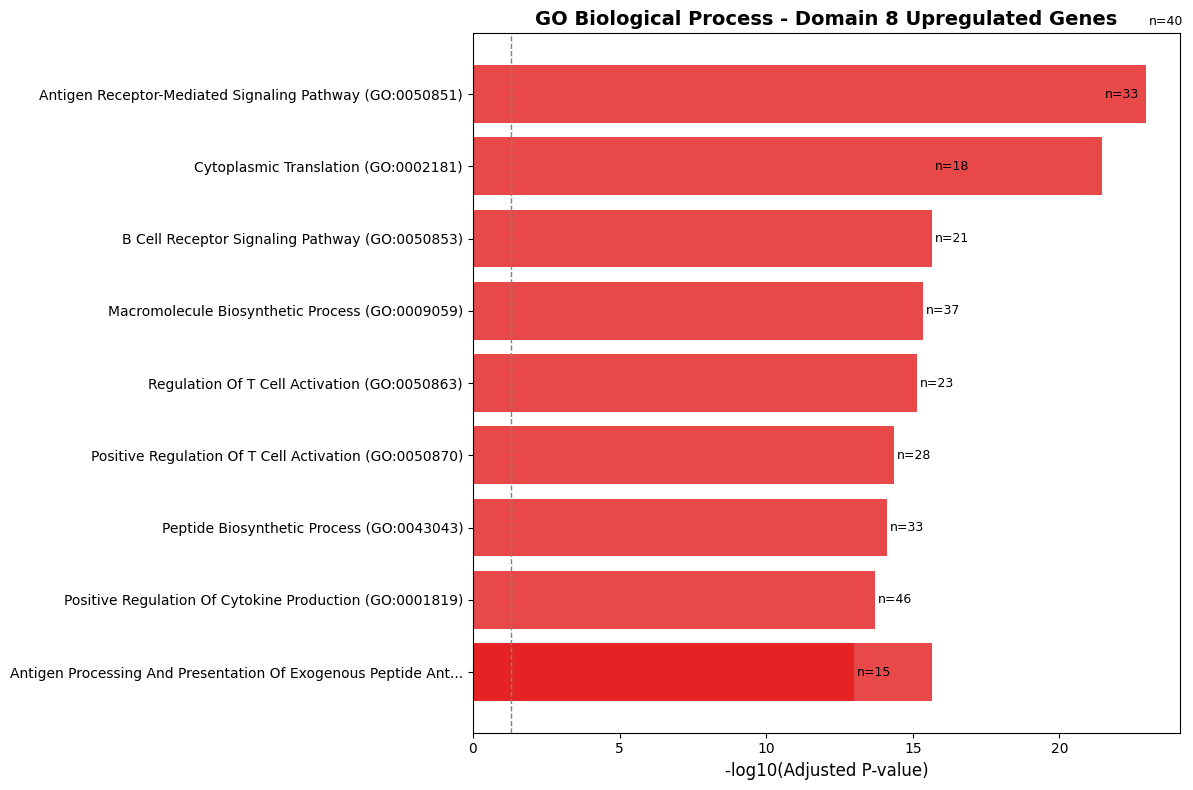

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/GO_BP_dotplot.png


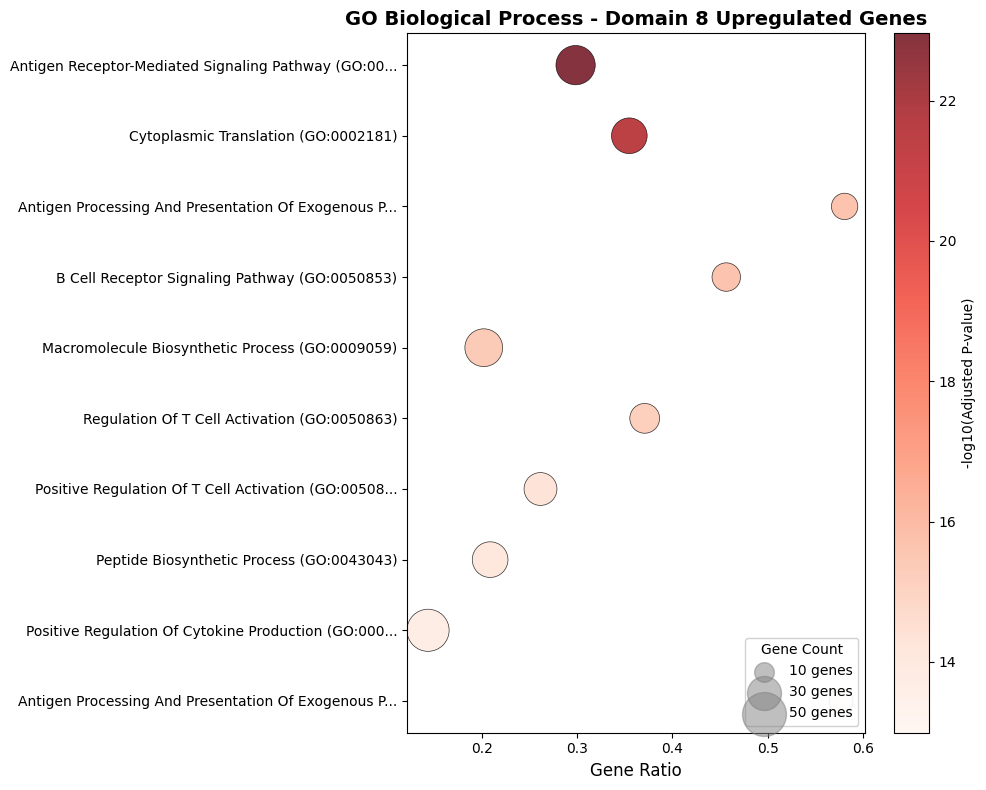

In [20]:
# ============================================
# Plot GO Biological Process Results
# ============================================

if 'GO_Biological_Process_2023' in enrichment_results and not enrichment_results['GO_Biological_Process_2023'].empty:
    go_bp_df = enrichment_results['GO_Biological_Process_2023']
    
    # Bar plot
    plot_enrichment_barplot(
        go_bp_df,
        title='GO Biological Process - Domain 8 Upregulated Genes',
        top_n=10,
        output_path=os.path.join(ENRICHMENT_DIR, 'GO_BP_barplot.png'),
        color='#E41A1C'
    )
    
    # Dot plot
    plot_enrichment_dotplot(
        go_bp_df,
        title='GO Biological Process - Domain 8 Upregulated Genes',
        top_n=10,
        output_path=os.path.join(ENRICHMENT_DIR, 'GO_BP_dotplot.png')
    )
else:
    print("No GO Biological Process results available")

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/GO_MF_barplot.png


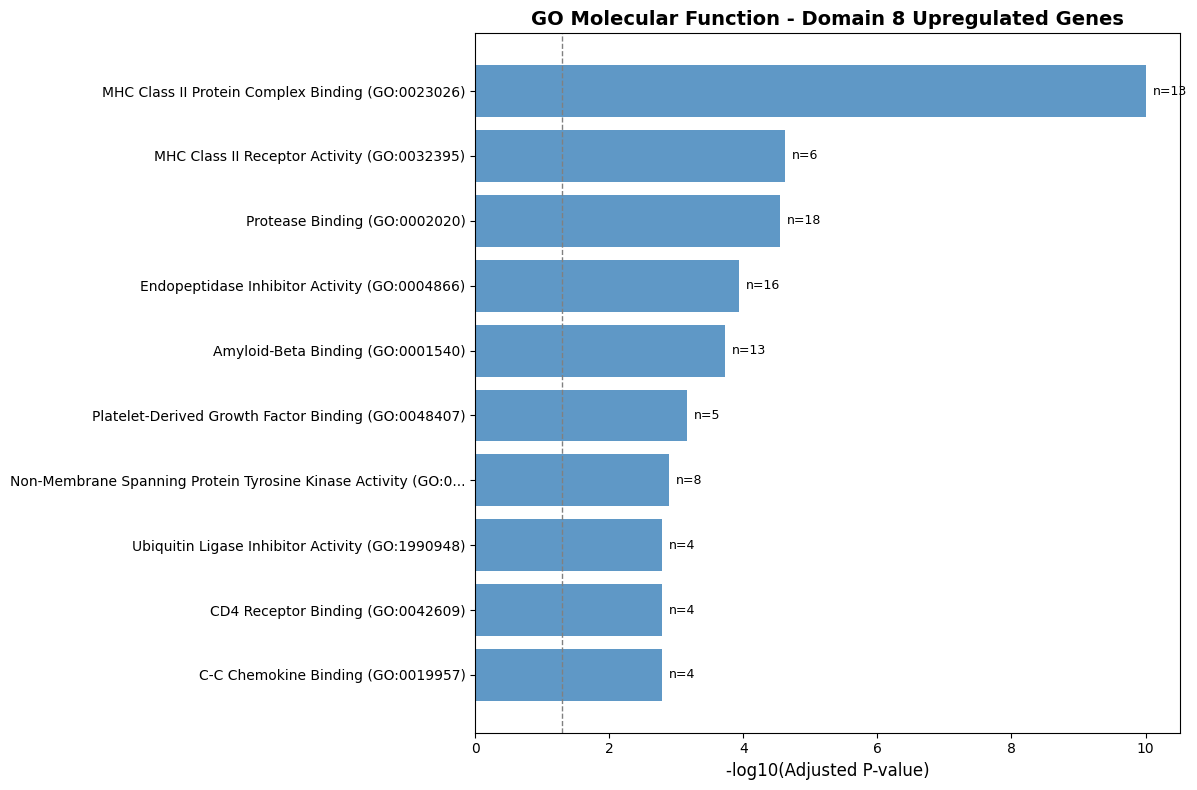

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/GO_MF_dotplot.png


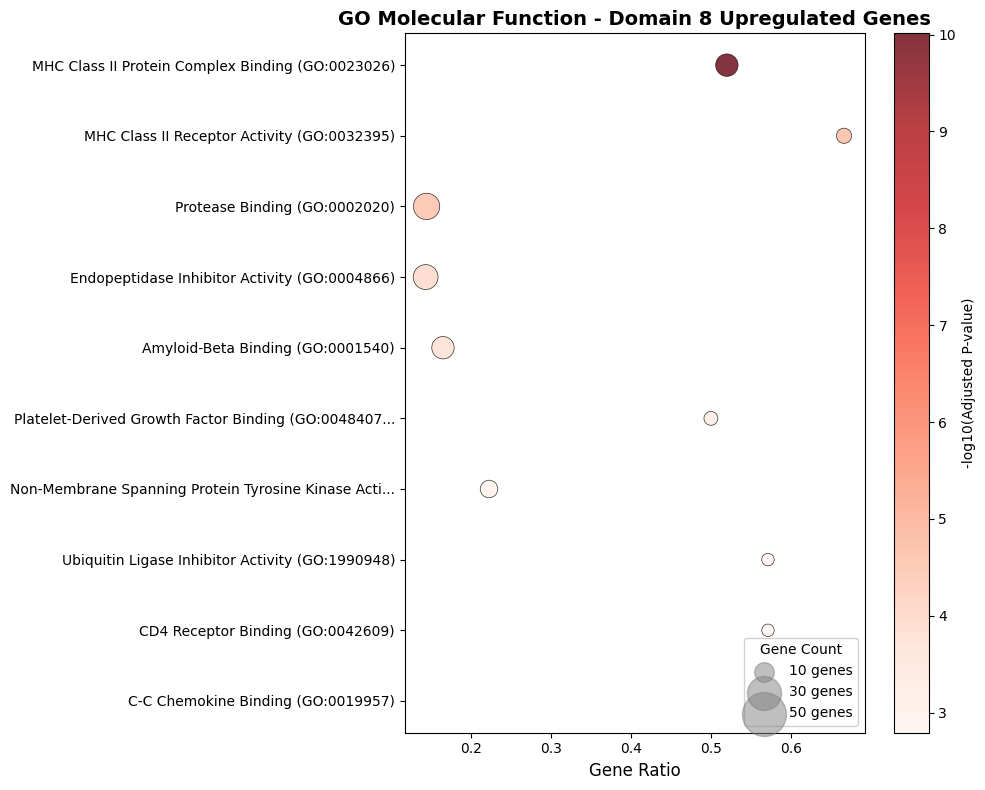

In [21]:
# ============================================
# Plot GO Molecular Function Results
# ============================================

if 'GO_Molecular_Function_2023' in enrichment_results and not enrichment_results['GO_Molecular_Function_2023'].empty:
    go_mf_df = enrichment_results['GO_Molecular_Function_2023']
    
    # Bar plot
    plot_enrichment_barplot(
        go_mf_df,
        title='GO Molecular Function - Domain 8 Upregulated Genes',
        top_n=10,
        output_path=os.path.join(ENRICHMENT_DIR, 'GO_MF_barplot.png'),
        color='#377EB8'
    )
    
    # Dot plot
    plot_enrichment_dotplot(
        go_mf_df,
        title='GO Molecular Function - Domain 8 Upregulated Genes',
        top_n=10,
        output_path=os.path.join(ENRICHMENT_DIR, 'GO_MF_dotplot.png')
    )
else:
    print("No GO Molecular Function results available")

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/GO_CC_barplot.png


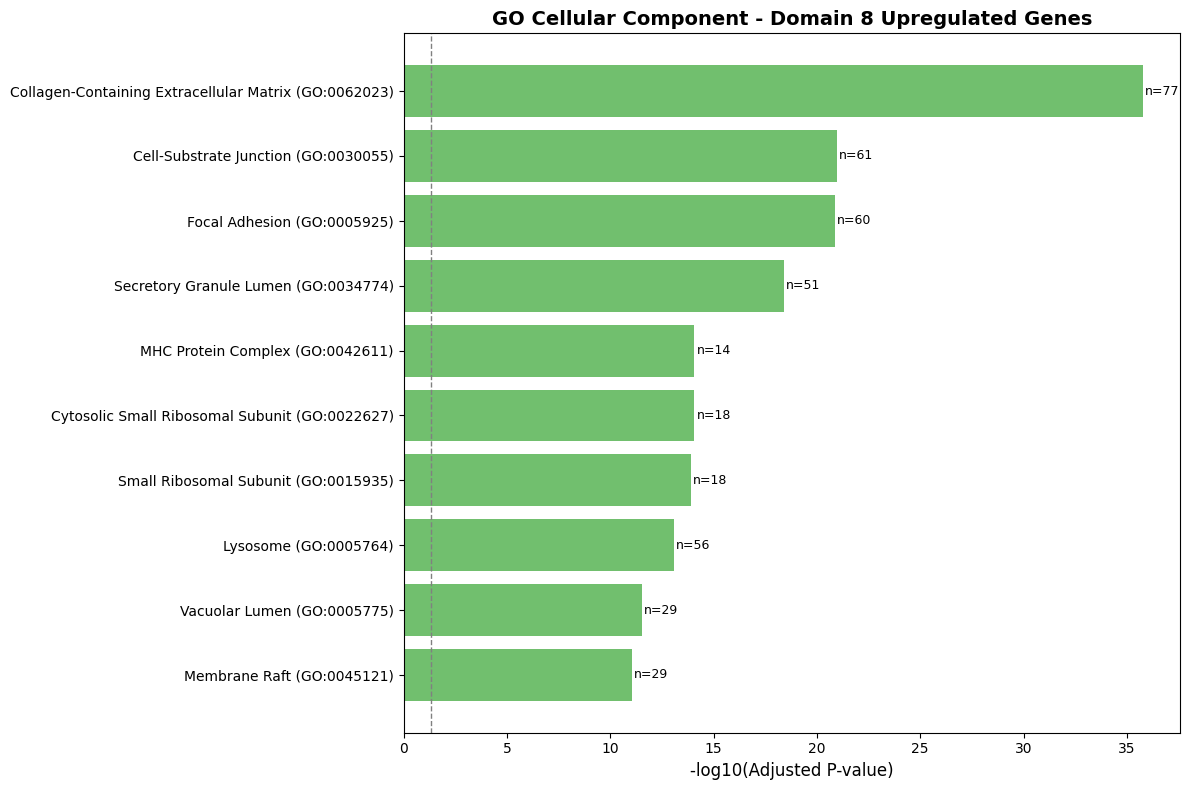

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/GO_CC_dotplot.png


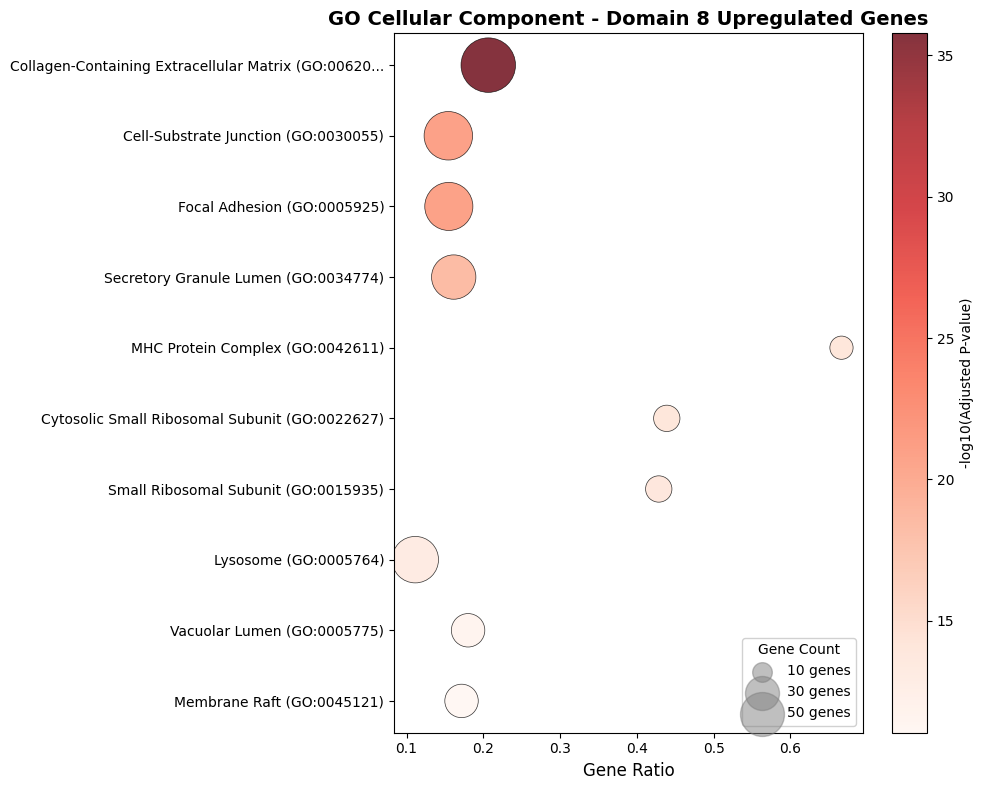

In [22]:
# ============================================
# Plot GO Cellular Component Results
# ============================================

if 'GO_Cellular_Component_2023' in enrichment_results and not enrichment_results['GO_Cellular_Component_2023'].empty:
    go_cc_df = enrichment_results['GO_Cellular_Component_2023']
    
    # Bar plot
    plot_enrichment_barplot(
        go_cc_df,
        title='GO Cellular Component - Domain 8 Upregulated Genes',
        top_n=10,
        output_path=os.path.join(ENRICHMENT_DIR, 'GO_CC_barplot.png'),
        color='#4DAF4A'
    )
    
    # Dot plot
    plot_enrichment_dotplot(
        go_cc_df,
        title='GO Cellular Component - Domain 8 Upregulated Genes',
        top_n=10,
        output_path=os.path.join(ENRICHMENT_DIR, 'GO_CC_dotplot.png')
    )
else:
    print("No GO Cellular Component results available")

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/KEGG_barplot.png


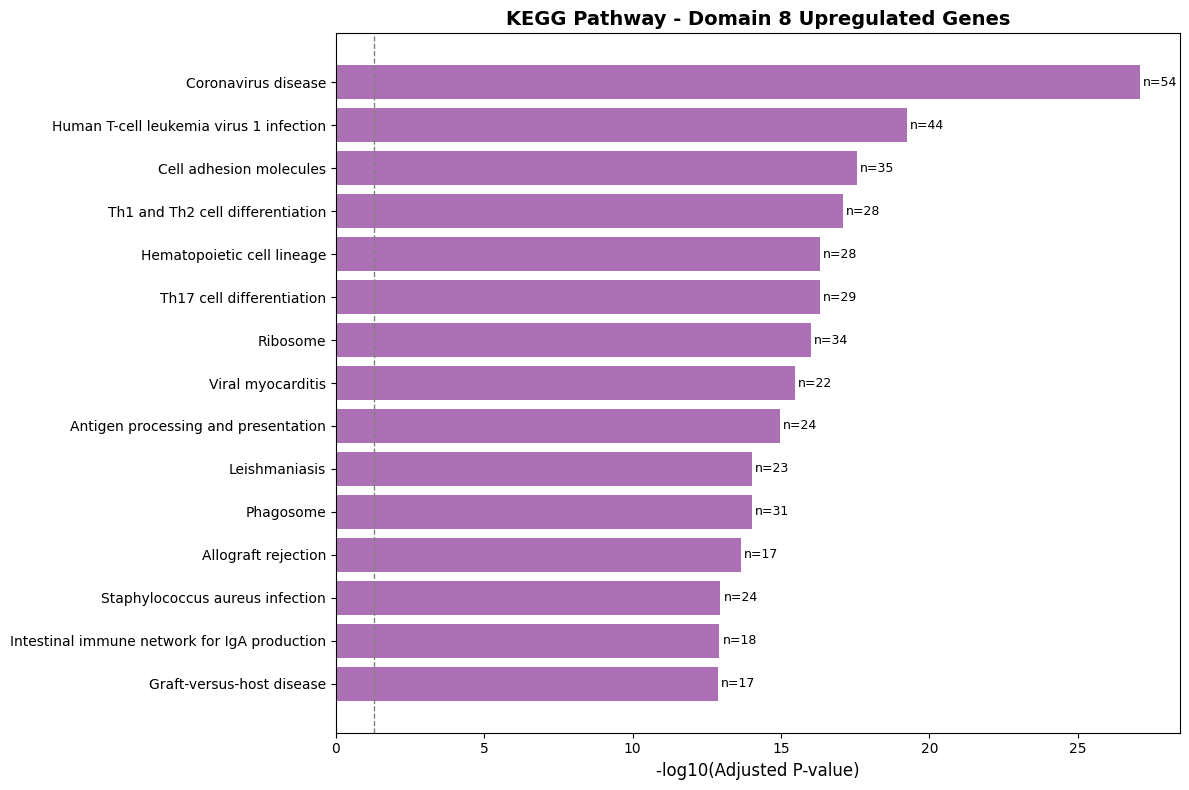

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/KEGG_dotplot.png


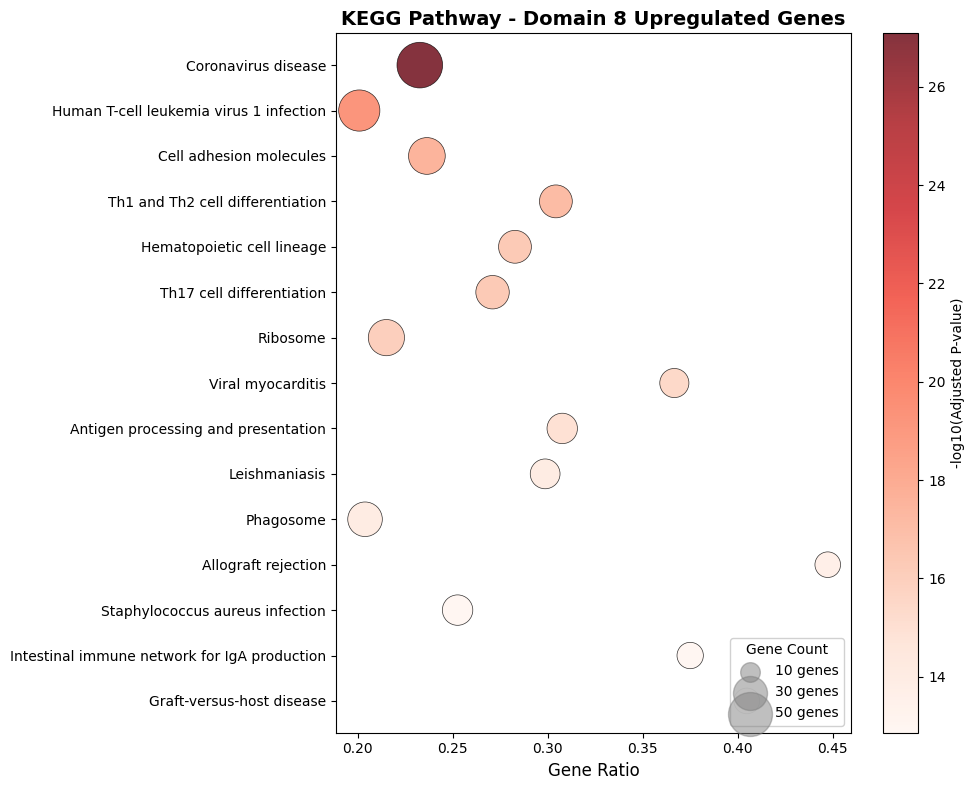

In [23]:
# ============================================
# Plot KEGG Pathway Results
# ============================================

if 'KEGG_2021_Human' in enrichment_results and not enrichment_results['KEGG_2021_Human'].empty:
    kegg_df = enrichment_results['KEGG_2021_Human']
    
    # Bar plot
    plot_enrichment_barplot(
        kegg_df,
        title='KEGG Pathway - Domain 8 Upregulated Genes',
        top_n=15,
        output_path=os.path.join(ENRICHMENT_DIR, 'KEGG_barplot.png'),
        color='#984EA3'
    )
    
    # Dot plot
    plot_enrichment_dotplot(
        kegg_df,
        title='KEGG Pathway - Domain 8 Upregulated Genes',
        top_n=15,
        output_path=os.path.join(ENRICHMENT_DIR, 'KEGG_dotplot.png')
    )
else:
    print("No KEGG pathway results available")

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/enrichment/combined_enrichment.png


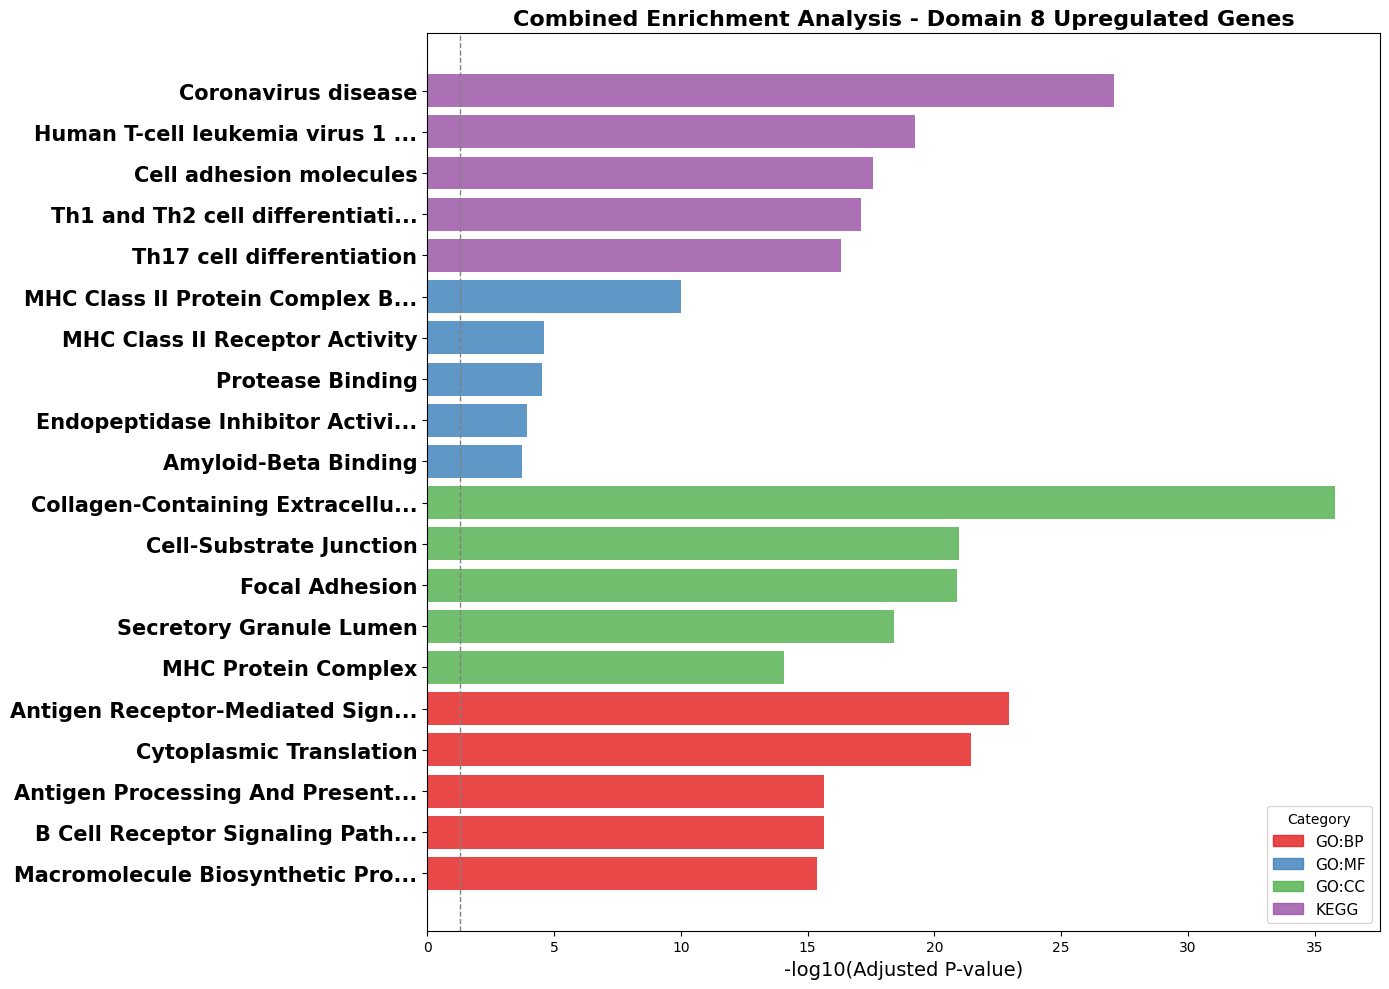

In [24]:
# ============================================
# Combined Summary Plot: Top Terms from All Categories
# ============================================

def plot_combined_enrichment(enrichment_results, top_n_per_category=5, output_path=None, figsize=(14, 10), 
                             max_term_length=30, fontsize=15):
    """
    Create a combined plot showing top terms from GO BP, MF, CC and KEGG.
    
    Parameters:
    -----------
    max_term_length : int
        Maximum characters for pathway name (longer names will be truncated with '...')
    fontsize : int
        Font size for pathway names
    """
    all_terms = []
    category_colors = {
        'GO_Biological_Process_2023': '#E41A1C',
        'GO_Molecular_Function_2023': '#377EB8',
        'GO_Cellular_Component_2023': '#4DAF4A',
        'KEGG_2021_Human': '#984EA3'
    }
    category_labels = {
        'GO_Biological_Process_2023': 'GO:BP',
        'GO_Molecular_Function_2023': 'GO:MF',
        'GO_Cellular_Component_2023': 'GO:CC',
        'KEGG_2021_Human': 'KEGG'
    }
    
    for cat, df in enrichment_results.items():
        if df.empty:
            continue
        sig_df = df[df['Adjusted P-value'] < 0.05].head(top_n_per_category).copy()
        if not sig_df.empty:
            sig_df['Category'] = cat
            sig_df['Category_label'] = category_labels.get(cat, cat)
            all_terms.append(sig_df)
    
    if not all_terms:
        print("No significant enrichment results to plot")
        return
    
    combined_df = pd.concat(all_terms, ignore_index=True)
    combined_df['neg_log10_pval'] = -np.log10(combined_df['Adjusted P-value'] + 1e-300)
    
    # Extract pathway name only (remove GO ID like "GO:0000218" pattern)
    import re
    def clean_term_name(term, max_len=max_term_length):
        # Remove GO ID pattern (GO:XXXXXXX) from term name
        cleaned = re.sub(r'\s*\(GO:\d+\)\s*$', '', term)
        # Truncate if too long
        if len(cleaned) > max_len:
            cleaned = cleaned[:max_len] + '...'
        return cleaned
    
    combined_df['Term_short'] = combined_df['Term'].apply(clean_term_name)
    
    # Sort by category then by p-value
    combined_df = combined_df.sort_values(['Category', 'neg_log10_pval'], ascending=[True, True])
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    
    y_pos = range(len(combined_df))
    colors = [category_colors.get(cat, 'gray') for cat in combined_df['Category']]
    
    bars = ax.barh(y_pos, combined_df['neg_log10_pval'], color=colors, alpha=0.8)
    
    ax.set_yticks(y_pos)
    # Show only pathway name without category tag, with larger font
    ax.set_yticklabels([row['Term_short'] for _, row in combined_df.iterrows()], 
                       fontsize=fontsize, fontweight='bold')
    ax.set_xlabel('-log10(Adjusted P-value)', fontsize=14)
    ax.set_title('Combined Enrichment Analysis - Domain 8 Upregulated Genes', fontsize=16, fontweight='bold')
    ax.axvline(x=-np.log10(0.05), color='gray', linestyle='--', linewidth=1)
    
    # Add legend
    legend_patches = [plt.Rectangle((0,0),1,1, color=color, alpha=0.8) 
                      for color in category_colors.values()]
    ax.legend(legend_patches, [category_labels[k] for k in category_colors.keys()], 
              loc='lower right', title='Category', fontsize=11)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.savefig(output_path.replace('.png', '.pdf'), bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    plt.show()

# Plot combined summary
plot_combined_enrichment(
    enrichment_results,
    top_n_per_category=5,
    output_path=os.path.join(ENRICHMENT_DIR, 'combined_enrichment.png'),
    max_term_length=30,  # 글자수 제한 (이 이상은 ...으로 표시)
    fontsize=15         # 글씨 크기
)

In [25]:
# ============================================
# Display Top Enrichment Results as Tables
# ============================================

print("=" * 80)
print("TOP 10 GO Biological Process Terms")
print("=" * 80)
if 'GO_Biological_Process_2023' in enrichment_results and not enrichment_results['GO_Biological_Process_2023'].empty:
    display_cols = ['Term', 'Overlap', 'Adjusted P-value', 'Genes']
    print(enrichment_results['GO_Biological_Process_2023'][display_cols].head(10).to_string())
else:
    print("No results")

print("\n" + "=" * 80)
print("TOP 10 GO Molecular Function Terms")
print("=" * 80)
if 'GO_Molecular_Function_2023' in enrichment_results and not enrichment_results['GO_Molecular_Function_2023'].empty:
    print(enrichment_results['GO_Molecular_Function_2023'][display_cols].head(10).to_string())
else:
    print("No results")

print("\n" + "=" * 80)
print("TOP 10 GO Cellular Component Terms")
print("=" * 80)
if 'GO_Cellular_Component_2023' in enrichment_results and not enrichment_results['GO_Cellular_Component_2023'].empty:
    print(enrichment_results['GO_Cellular_Component_2023'][display_cols].head(10).to_string())
else:
    print("No results")

print("\n" + "=" * 80)
print("TOP 10 KEGG Pathways")
print("=" * 80)
if 'KEGG_2021_Human' in enrichment_results and not enrichment_results['KEGG_2021_Human'].empty:
    print(enrichment_results['KEGG_2021_Human'][display_cols].head(10).to_string())
else:
    print("No results")

TOP 10 GO Biological Process Terms
                                                                                             Term Overlap  Adjusted P-value                                                                                                                                                                                                                                                                              Genes
0                                        Antigen Receptor-Mediated Signaling Pathway (GO:0050851)  40/134      1.093299e-23                                         BLK;IGHM;PIK3CD;CD3G;THY1;CD3E;CD3D;IGHG3;CD79B;IGHG4;CD79A;IGHG1;IGHG2;IGKC;TRBC2;CD19;INPP5D;TRBC1;IGLC3;NCKAP1L;IGLC1;CSK;FYN;IGHA1;IGHA2;HLA-DPA1;FYB1;BTN3A1;PRKCB;HLA-A;LIME1;ZAP70;PTPRC;THEMIS2;CD8A;LCK;LCP2;CD247;MS4A1;HLA-DRB1
1                                                            Cytoplasmic Translation (GO:0002181)   33/93      3.438385e-22                                            

In [26]:
# ============================================
# GO & KEGG Analysis for Subregion DEGs (Left Lower vs Center/Right)
# ============================================

# Create output directory for subregion enrichment
ENRICHMENT_DIR_SUB = os.path.join(OUTPUT_DIR_SUB, 'enrichment')
os.makedirs(ENRICHMENT_DIR_SUB, exist_ok=True)

# Get upregulated genes in Left Lower region
deg_leftlower_up_genes = deg_subregion_df[
    (deg_subregion_df['logfoldchanges'] > 0.25) & 
    (deg_subregion_df['pvals_adj'] < 0.05)
]['gene'].tolist()

# Get upregulated genes in Center/Right region (downregulated in left_lower)
deg_centerright_up_genes = deg_subregion_df[
    (deg_subregion_df['logfoldchanges'] < -0.25) & 
    (deg_subregion_df['pvals_adj'] < 0.05)
]['gene'].tolist()

print(f"Left Lower upregulated genes: {len(deg_leftlower_up_genes)}")
print(f"Center/Right upregulated genes: {len(deg_centerright_up_genes)}")
print(f"\nLeft Lower genes: {deg_leftlower_up_genes}")
print(f"\nCenter/Right genes: {deg_centerright_up_genes}")

Left Lower upregulated genes: 4
Center/Right upregulated genes: 25

Left Lower genes: ['IGHA1', 'CD79A', 'DNAJC5', 'H2AFJ']

Center/Right genes: ['EMILIN1', 'HLA-DRB5', 'ANXA5', 'COL6A3', 'COL3A1', 'COL6A2', 'IGFBP7', 'TIMP3', 'C1QC', 'C3', 'SFRP4', 'DCN', 'CD74', 'SFRP2', 'FSTL1', 'COL1A1', 'SPARC', 'CCDC80', 'S100A10', 'IGFBP4', 'C1QB', 'S100A6', 'VCAN', 'BGN', 'TIMP1']


In [27]:
# ============================================
# Run Enrichment for Left Lower Upregulated Genes
# ============================================

if len(deg_leftlower_up_genes) >= 5:
    print("=" * 60)
    print("Enrichment Analysis: Left Lower Upregulated Genes")
    print("=" * 60)
    
    enrichment_leftlower = run_enrichment_analysis(
        gene_list=deg_leftlower_up_genes,
        gene_sets=GENE_SETS,
        organism='human',
        output_dir=ENRICHMENT_DIR_SUB,
        prefix='leftlower_up_'
    )
else:
    print(f"Too few genes ({len(deg_leftlower_up_genes)}) for Left Lower enrichment analysis (minimum 5 required)")
    enrichment_leftlower = {}

Too few genes (4) for Left Lower enrichment analysis (minimum 5 required)


In [28]:
# ============================================
# Run Enrichment for Center/Right Upregulated Genes
# ============================================

if len(deg_centerright_up_genes) >= 5:
    print("=" * 60)
    print("Enrichment Analysis: Center/Right Upregulated Genes")
    print("=" * 60)
    
    enrichment_centerright = run_enrichment_analysis(
        gene_list=deg_centerright_up_genes,
        gene_sets=GENE_SETS,
        organism='human',
        output_dir=ENRICHMENT_DIR_SUB,
        prefix='centerright_up_'
    )
else:
    print(f"Too few genes ({len(deg_centerright_up_genes)}) for Center/Right enrichment analysis (minimum 5 required)")
    enrichment_centerright = {}

Enrichment Analysis: Center/Right Upregulated Genes

Running enrichment for: GO_Biological_Process_2023
  Found 390 enriched terms
  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment/centerright_up_enrichr_GO_Biological_Process_2023.csv

Running enrichment for: GO_Molecular_Function_2023
  Found 26 enriched terms
  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment/centerright_up_enrichr_GO_Molecular_Function_2023.csv

Running enrichment for: GO_Cellular_Component_2023
  Found 54 enriched terms
  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment/centerright_up_enrichr_GO_Cellular_Component_2023.csv

Running enrichment for: KEGG_2021_Human
  Found 51 enriched terms
  Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment/centerright_up_enrichr_KEGG_2021_Human.csv


In [29]:
# ============================================
# Plot Left Lower Enrichment Results
# ============================================

if enrichment_leftlower:
    print("=" * 60)
    print("Plotting Left Lower Enrichment Results")
    print("=" * 60)
    
    # GO BP
    if 'GO_Biological_Process_2023' in enrichment_leftlower and not enrichment_leftlower['GO_Biological_Process_2023'].empty:
        plot_enrichment_barplot(
            enrichment_leftlower['GO_Biological_Process_2023'],
            title='GO Biological Process - Left Lower Upregulated',
            top_n=10,
            output_path=os.path.join(ENRICHMENT_DIR_SUB, 'leftlower_GO_BP_barplot.png'),
            color='#E41A1C'
        )
    
    # GO MF
    if 'GO_Molecular_Function_2023' in enrichment_leftlower and not enrichment_leftlower['GO_Molecular_Function_2023'].empty:
        plot_enrichment_barplot(
            enrichment_leftlower['GO_Molecular_Function_2023'],
            title='GO Molecular Function - Left Lower Upregulated',
            top_n=10,
            output_path=os.path.join(ENRICHMENT_DIR_SUB, 'leftlower_GO_MF_barplot.png'),
            color='#377EB8'
        )
    
    # GO CC
    if 'GO_Cellular_Component_2023' in enrichment_leftlower and not enrichment_leftlower['GO_Cellular_Component_2023'].empty:
        plot_enrichment_barplot(
            enrichment_leftlower['GO_Cellular_Component_2023'],
            title='GO Cellular Component - Left Lower Upregulated',
            top_n=10,
            output_path=os.path.join(ENRICHMENT_DIR_SUB, 'leftlower_GO_CC_barplot.png'),
            color='#4DAF4A'
        )
    
    # KEGG
    if 'KEGG_2021_Human' in enrichment_leftlower and not enrichment_leftlower['KEGG_2021_Human'].empty:
        plot_enrichment_barplot(
            enrichment_leftlower['KEGG_2021_Human'],
            title='KEGG Pathway - Left Lower Upregulated',
            top_n=10,
            output_path=os.path.join(ENRICHMENT_DIR_SUB, 'leftlower_KEGG_barplot.png'),
            color='#984EA3'
        )
    
    # Combined plot
    plot_combined_enrichment(
        enrichment_leftlower,
        top_n_per_category=5,
        output_path=os.path.join(ENRICHMENT_DIR_SUB, 'leftlower_combined_enrichment.png')
    )
else:
    print("No Left Lower enrichment results to plot")

No Left Lower enrichment results to plot


Plotting Center/Right Enrichment Results
Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment/centerright_GO_BP_barplot.png


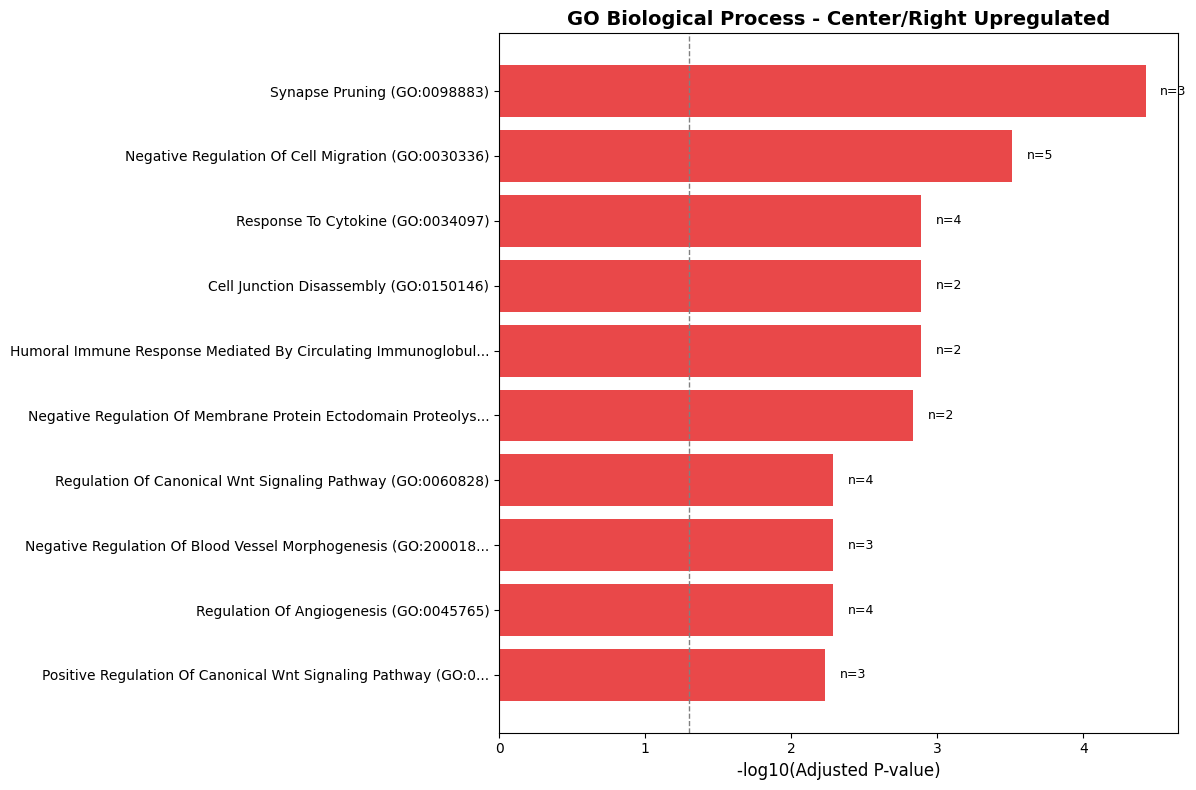

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment/centerright_GO_MF_barplot.png


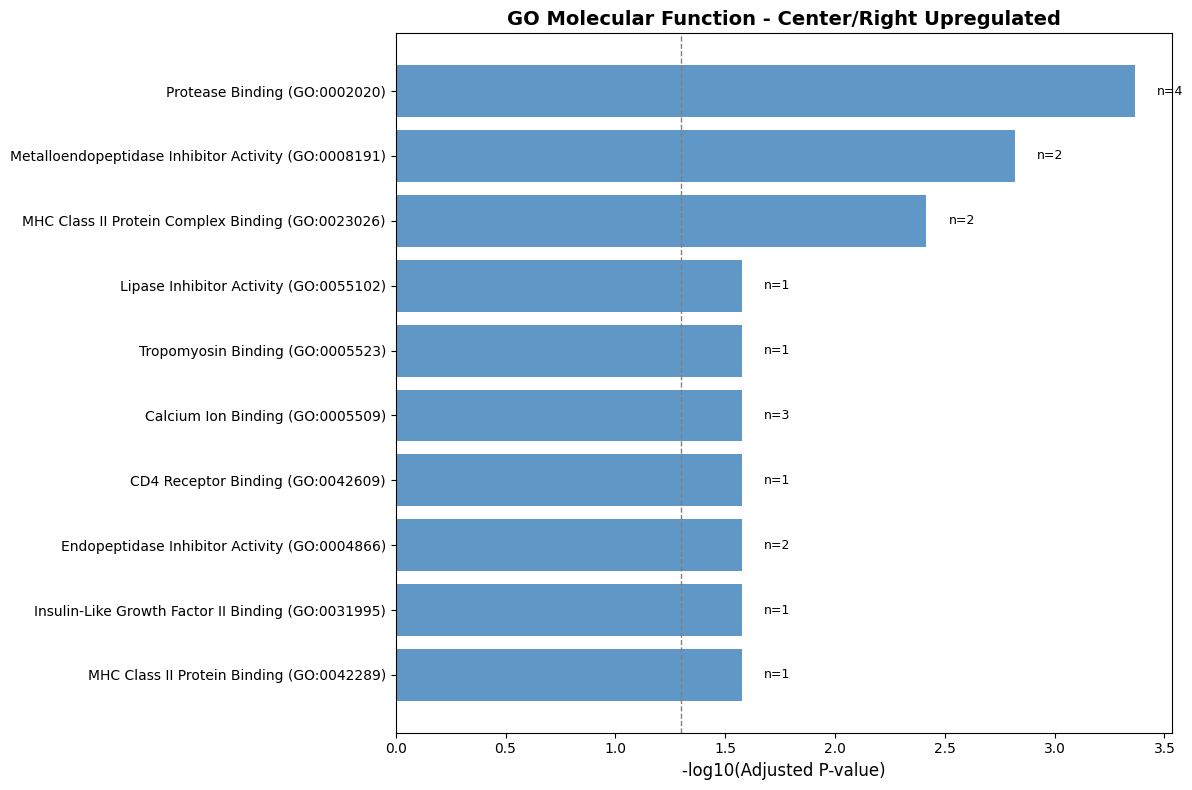

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment/centerright_GO_CC_barplot.png


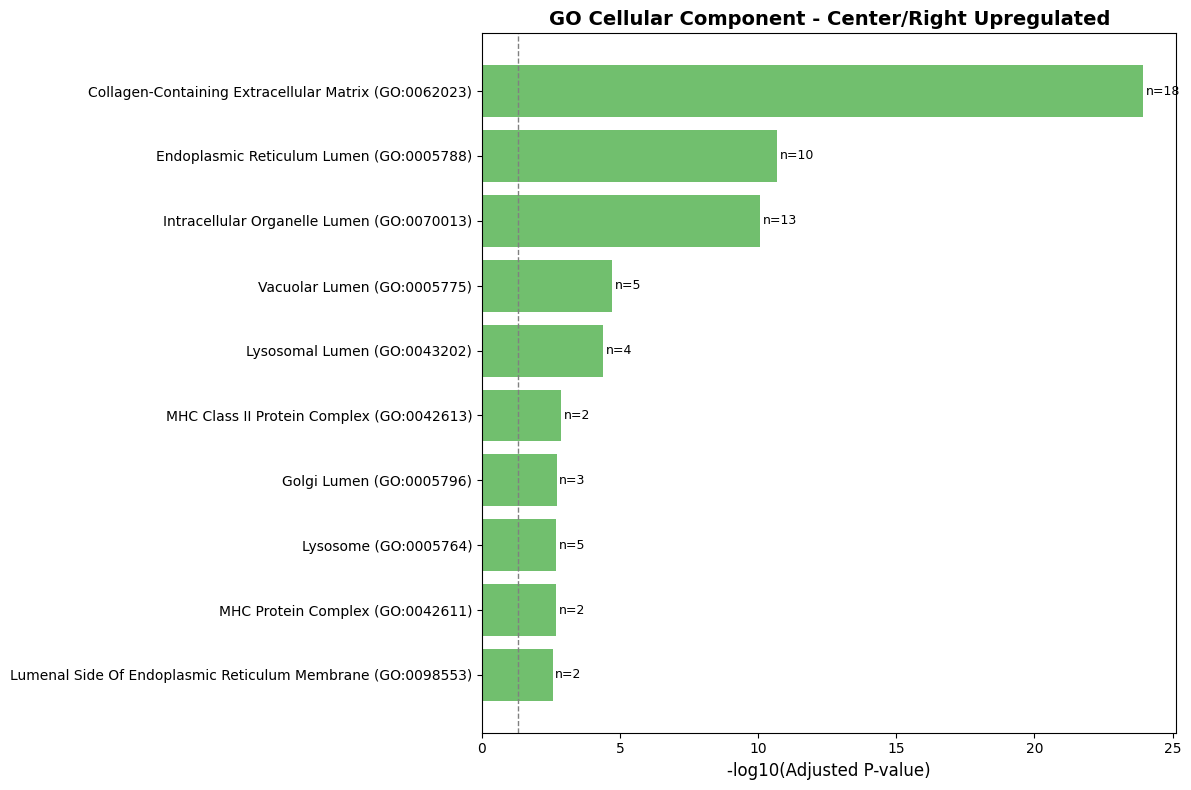

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment/centerright_KEGG_barplot.png


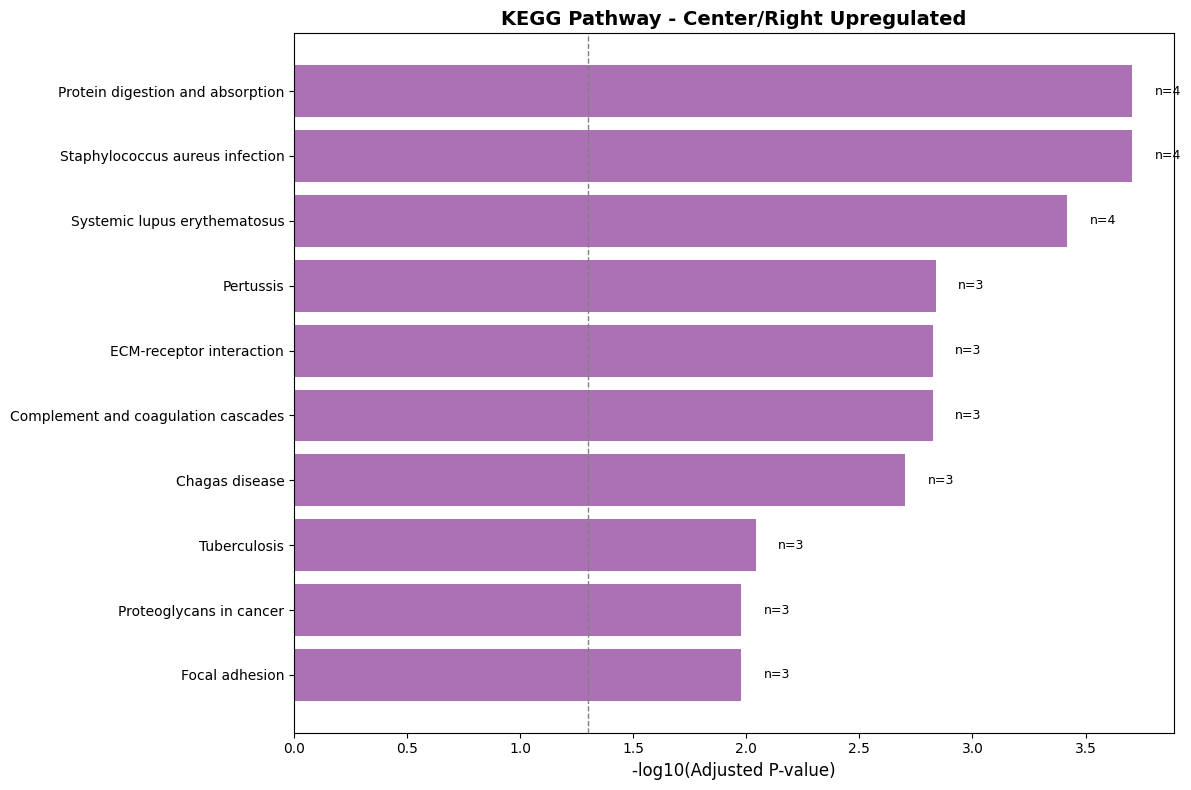

Saved: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment/centerright_combined_enrichment.png


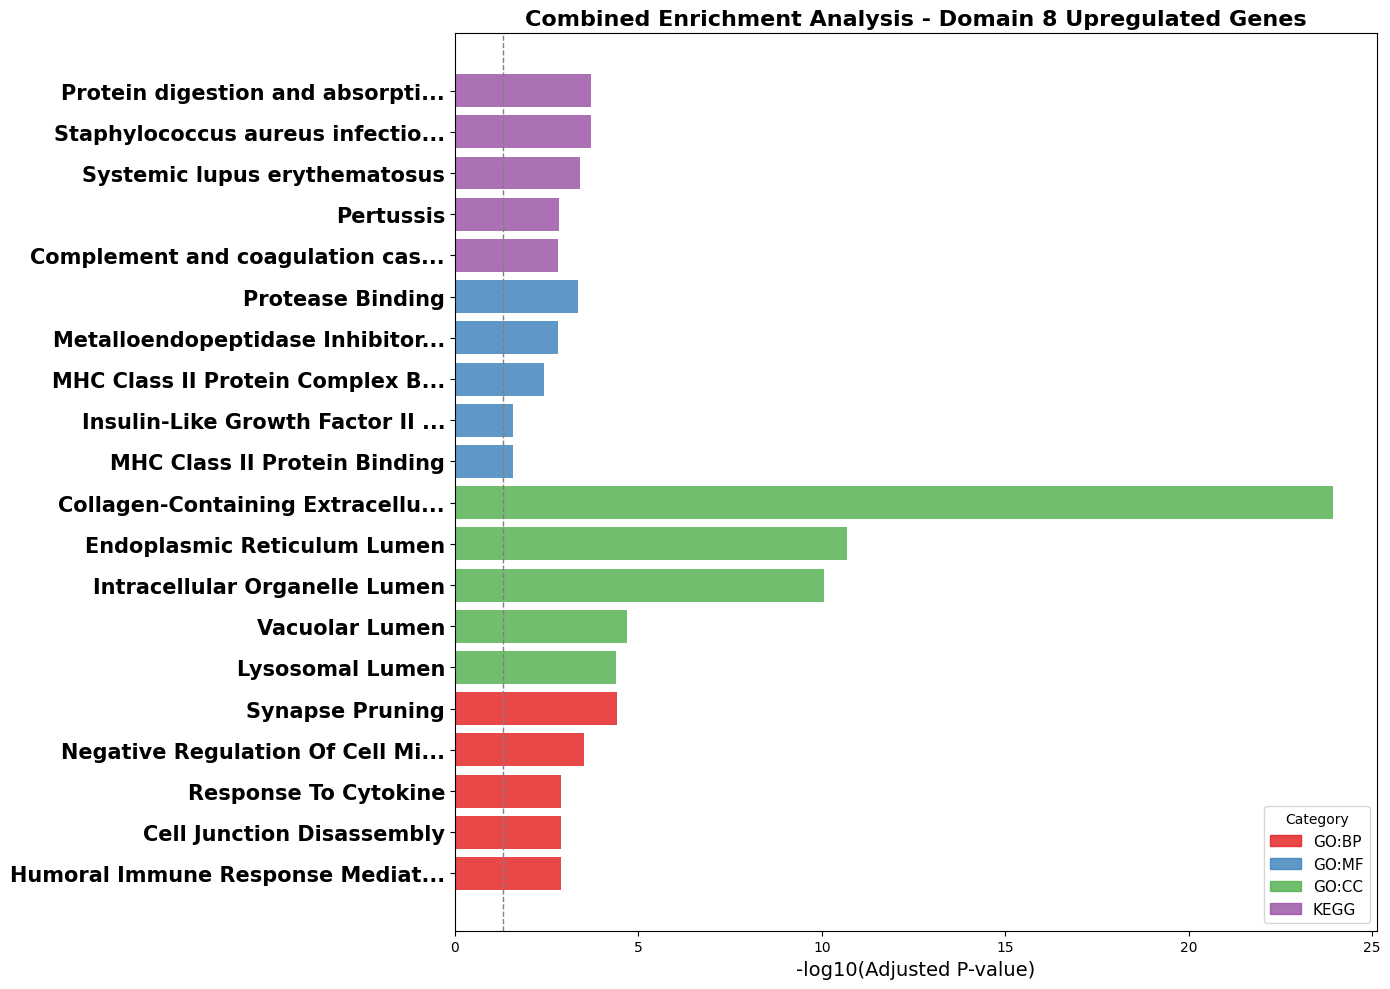

In [30]:
# ============================================
# Plot Center/Right Enrichment Results
# ============================================

if enrichment_centerright:
    print("=" * 60)
    print("Plotting Center/Right Enrichment Results")
    print("=" * 60)
    
    # GO BP
    if 'GO_Biological_Process_2023' in enrichment_centerright and not enrichment_centerright['GO_Biological_Process_2023'].empty:
        plot_enrichment_barplot(
            enrichment_centerright['GO_Biological_Process_2023'],
            title='GO Biological Process - Center/Right Upregulated',
            top_n=10,
            output_path=os.path.join(ENRICHMENT_DIR_SUB, 'centerright_GO_BP_barplot.png'),
            color='#E41A1C'
        )
    
    # GO MF
    if 'GO_Molecular_Function_2023' in enrichment_centerright and not enrichment_centerright['GO_Molecular_Function_2023'].empty:
        plot_enrichment_barplot(
            enrichment_centerright['GO_Molecular_Function_2023'],
            title='GO Molecular Function - Center/Right Upregulated',
            top_n=10,
            output_path=os.path.join(ENRICHMENT_DIR_SUB, 'centerright_GO_MF_barplot.png'),
            color='#377EB8'
        )
    
    # GO CC
    if 'GO_Cellular_Component_2023' in enrichment_centerright and not enrichment_centerright['GO_Cellular_Component_2023'].empty:
        plot_enrichment_barplot(
            enrichment_centerright['GO_Cellular_Component_2023'],
            title='GO Cellular Component - Center/Right Upregulated',
            top_n=10,
            output_path=os.path.join(ENRICHMENT_DIR_SUB, 'centerright_GO_CC_barplot.png'),
            color='#4DAF4A'
        )
    
    # KEGG
    if 'KEGG_2021_Human' in enrichment_centerright and not enrichment_centerright['KEGG_2021_Human'].empty:
        plot_enrichment_barplot(
            enrichment_centerright['KEGG_2021_Human'],
            title='KEGG Pathway - Center/Right Upregulated',
            top_n=10,
            output_path=os.path.join(ENRICHMENT_DIR_SUB, 'centerright_KEGG_barplot.png'),
            color='#984EA3'
        )
    
    # Combined plot
    plot_combined_enrichment(
        enrichment_centerright,
        top_n_per_category=5,
        output_path=os.path.join(ENRICHMENT_DIR_SUB, 'centerright_combined_enrichment.png')
    )
else:
    print("No Center/Right enrichment results to plot")

In [31]:
# ============================================
# Summary: Subregion Enrichment Comparison
# ============================================

print("=" * 80)
print("SUBREGION ENRICHMENT ANALYSIS SUMMARY")
print("=" * 80)

print(f"\n[Left Lower Region]")
print(f"  - Upregulated genes: {len(deg_leftlower_up_genes)}")
if deg_leftlower_up_genes:
    print(f"  - Gene list: {', '.join(deg_leftlower_up_genes[:20])}" + ("..." if len(deg_leftlower_up_genes) > 20 else ""))

print(f"\n[Center/Right Region]")
print(f"  - Upregulated genes: {len(deg_centerright_up_genes)}")
if deg_centerright_up_genes:
    print(f"  - Gene list: {', '.join(deg_centerright_up_genes[:20])}" + ("..." if len(deg_centerright_up_genes) > 20 else ""))

# Display top enrichment results for each region
display_cols = ['Term', 'Overlap', 'Adjusted P-value']

if enrichment_leftlower:
    print("\n" + "=" * 80)
    print("TOP 5 KEGG PATHWAYS - Left Lower")
    print("=" * 80)
    if 'KEGG_2021_Human' in enrichment_leftlower and not enrichment_leftlower['KEGG_2021_Human'].empty:
        print(enrichment_leftlower['KEGG_2021_Human'][display_cols].head(5).to_string())
    else:
        print("No significant KEGG results")

if enrichment_centerright:
    print("\n" + "=" * 80)
    print("TOP 5 KEGG PATHWAYS - Center/Right")
    print("=" * 80)
    if 'KEGG_2021_Human' in enrichment_centerright and not enrichment_centerright['KEGG_2021_Human'].empty:
        print(enrichment_centerright['KEGG_2021_Human'][display_cols].head(5).to_string())
    else:
        print("No significant KEGG results")

print("\n" + "=" * 80)
print(f"Results saved to: {ENRICHMENT_DIR_SUB}")
print("=" * 80)

SUBREGION ENRICHMENT ANALYSIS SUMMARY

[Left Lower Region]
  - Upregulated genes: 4
  - Gene list: IGHA1, CD79A, DNAJC5, H2AFJ

[Center/Right Region]
  - Upregulated genes: 25
  - Gene list: EMILIN1, HLA-DRB5, ANXA5, COL6A3, COL3A1, COL6A2, IGFBP7, TIMP3, C1QC, C3, SFRP4, DCN, CD74, SFRP2, FSTL1, COL1A1, SPARC, CCDC80, S100A10, IGFBP4...

TOP 5 KEGG PATHWAYS - Center/Right
                                  Term Overlap  Adjusted P-value
0      Staphylococcus aureus infection    4/95          0.000197
1     Protein digestion and absorption   4/103          0.000197
2         Systemic lupus erythematosus   4/135          0.000382
3                            Pertussis    3/76          0.001456
4  Complement and coagulation cascades    3/85          0.001500

Results saved to: ../../results/spatial_clustering/st_conma/human_breast_cancer/domain_8/subregion_deg/enrichment
